Import relevant Libaries 

In [32]:
# Base libraries
import pandas as pd
import numpy as np
import os
import math as math
import datetime
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

# Visualizations
import matplotlib.pyplot as plt
from matplotlib import pyplot

# TS
from statsmodels.tsa.seasonal import seasonal_decompose

# Cyclical features
from feature_engine.creation import CyclicalFeatures

# Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import GridSearchCV, ShuffleSplit

# Set WD
import glob
import os
from pyrsistent import v
os.getcwd()

'/Users/nilsfulde/Desktop/Master_Thesis/scripts'

## Load Stations

In [3]:
# This bit to define the data that is to be loaded

# Define the directory path where the CSV files are located
input_path = r'../data/promice/preprocessed/daily/'

# Define a pattern to match the filenames of the CSV files
pattern = '*.csv'

# Use glob to get a list of all files that match the pattern
filenames = glob.glob(input_path + pattern)

dfs = []
for file in filenames:
    df = pd.read_csv(file, index_col=False)
    dfs.append(df)
df = pd.concat(dfs)

In [4]:
stations = [
'KPC_L',
'SCO_L',
'SCO_U',
'THU_L',
'UPE_L',
'UPE_U',
'MIT',
'TAS_L',
'KAN_L',
'NUK_L',
'NUK_U',
'QAS_L',
'QAS_U',]

df = df[df['stid'].isin(stations)]

## Pre-processing 0.1 (Pre-Modelling Considerations)

In [6]:
## This bit to detect melt onset & melt end day based on the ablation columns
df["Datetime"] = pd.to_datetime(df["Datetime"], format="%Y-%m-%d")
df['Year'] = df['Datetime'].dt.year
df['DayOfYear'] = df['Datetime'].dt.dayofyear

# Initialize new columns with default values
df['first_melt_day'] = False
df['last_melt_day'] = False

for i in df["stid"].unique().tolist():
    df_station = df[df['stid'] == i]
    unique_years = df_station['Year'].unique()
    for year in unique_years:
        # Filter data for the current year
        year_data = df_station[df_station['Year'] == year]

        # Find the first and last melt day
        first_melt_day = year_data.loc[year_data['Ablation'] == True]['DayOfYear'].min()
        last_melt_day = year_data.loc[year_data['Ablation'] == True]['DayOfYear'].max()

        # Update the original DataFrame
        df.loc[(df['stid'] == i) & (df['Year'] == year) & (df['DayOfYear'] == first_melt_day), 'first_melt_day'] = True
        df.loc[(df['stid'] == i) & (df['Year'] == year) & (df['DayOfYear'] == last_melt_day), 'last_melt_day'] = True

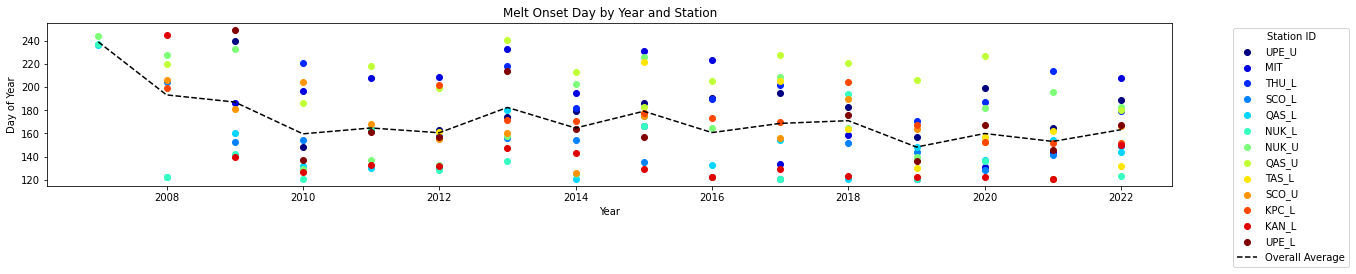

In [7]:
## This bit to visualize the melt onset days

# Extract the year and day of year from the 'Datetime' column
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['year'] = df['Datetime'].dt.year
df['day_of_year'] = df['Datetime'].dt.dayofyear

# Filter the dataframe for rows with 'first_melt_day' equal to True
melt_df = df[df['first_melt_day']]

# Get a list of unique 'stid' values and assign a unique color to each
unique_stids = melt_df['stid'].unique()
colors = plt.cm.jet(np.linspace(0, 1, len(unique_stids)))

# Create the scatter plot
fig, ax = plt.subplots(figsize=(25,3))

for stid, color in zip(unique_stids, colors):
    stid_df = melt_df[melt_df['stid'] == stid]
    ax.scatter(stid_df['year'], stid_df['day_of_year'], c=[color], label=stid)

# Calculate the overall average day of year for each year
average_days = melt_df.groupby('year')['day_of_year'].mean().reset_index()

# Plot the overall average day of year
ax.plot(average_days['year'], average_days['day_of_year'], linestyle='dashed', color='black', label='Overall Average')

# Set plot labels and move the legend to the outside right
ax.set_xlabel('Year')
ax.set_ylabel('Day of Year')
ax.set_title('Melt Onset Day by Year and Station')
ax.legend(title='Station ID', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust the plot layout to accommodate the legend
plt.subplots_adjust(right=0.75)

# Show the plot
plt.show()


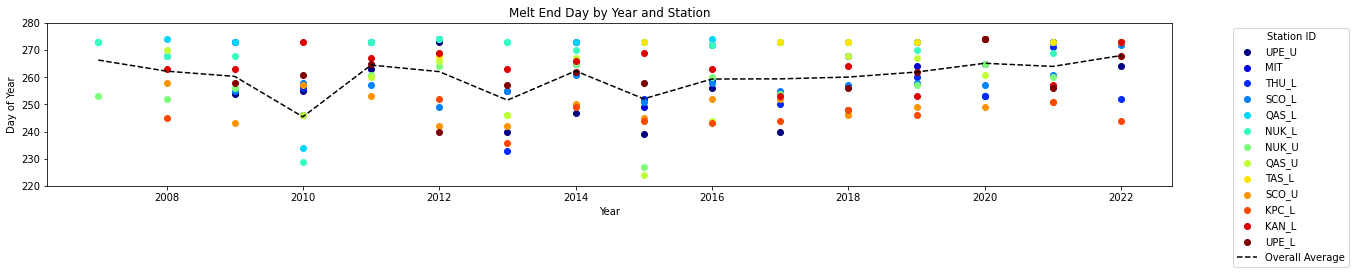

In [8]:
## This bit to visualize the melt end days

# Extract the year and day of year from the 'Datetime' column
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['year'] = df['Datetime'].dt.year
df['day_of_year'] = df['Datetime'].dt.dayofyear

# Filter the dataframe for rows with 'first_melt_day' equal to True
melt_df = df[df['last_melt_day']]

# Get a list of unique 'stid' values and assign a unique color to each
unique_stids = melt_df['stid'].unique()
colors = plt.cm.jet(np.linspace(0, 1, len(unique_stids)))

# Create the scatter plot
fig, ax = plt.subplots(figsize=(25,3))

for stid, color in zip(unique_stids, colors):
    stid_df = melt_df[melt_df['stid'] == stid]
    ax.scatter(stid_df['year'], stid_df['day_of_year'], c=[color], label=stid)

# Calculate the overall average day of year for each year
average_days = melt_df.groupby('year')['day_of_year'].mean().reset_index()

# Plot the overall average day of year
ax.plot(average_days['year'], average_days['day_of_year'], linestyle='dashed', color='black', label='Overall Average')

# Set plot labels and move the legend to the outside right
ax.set_xlabel('Year')
ax.set_ylabel('Day of Year')
ax.set_ylim(220,280)
ax.set_title('Melt End Day by Year and Station')
ax.legend(title='Station ID', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust the plot layout to accommodate the legend
plt.subplots_adjust(right=0.75)

# Show the plot
plt.show()


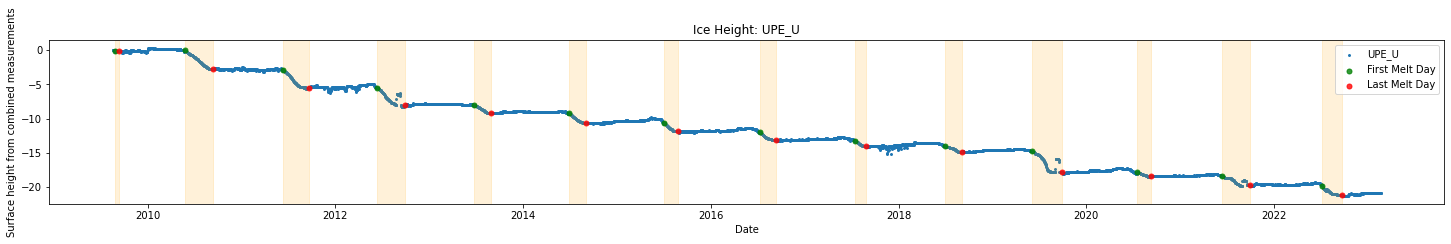

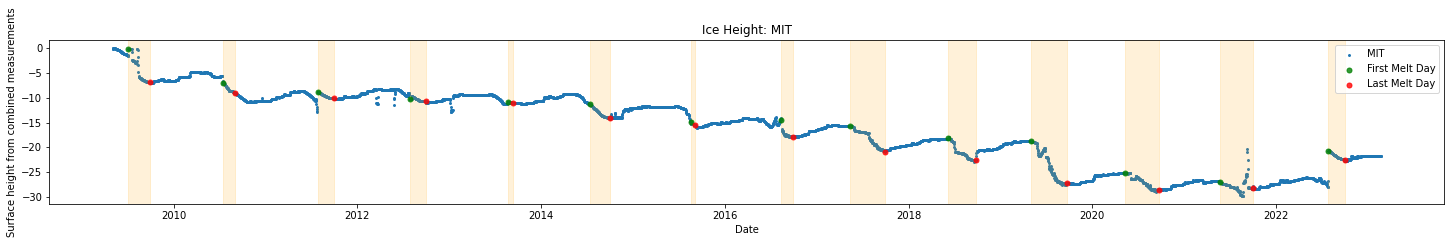

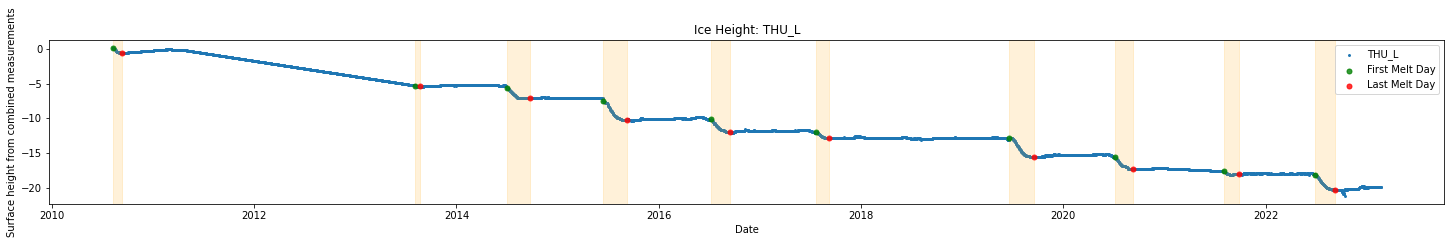

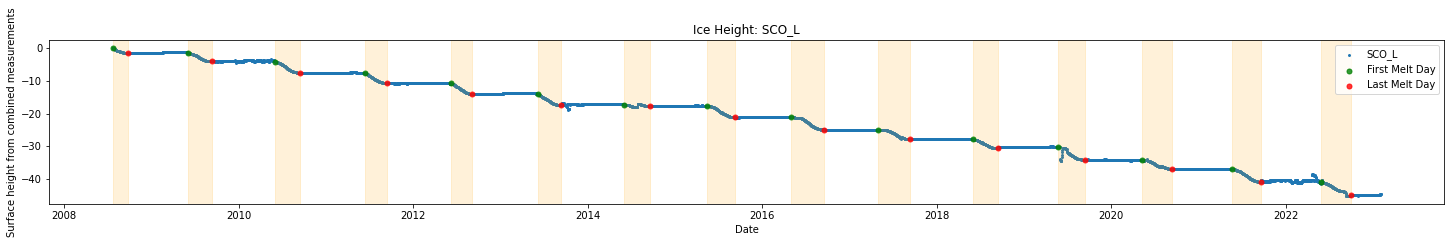

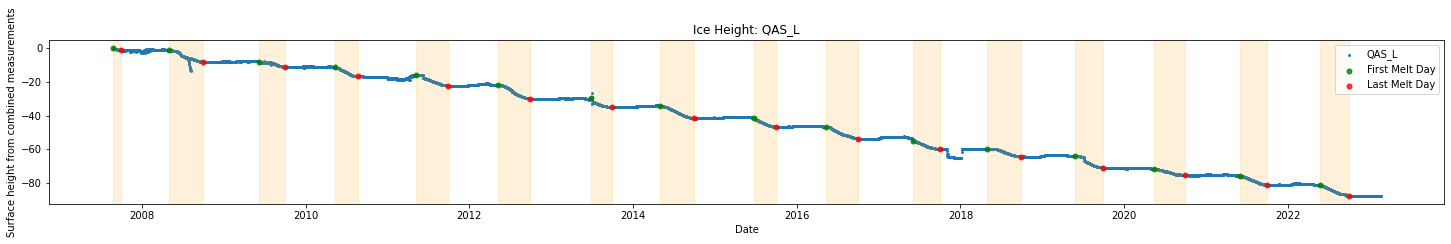

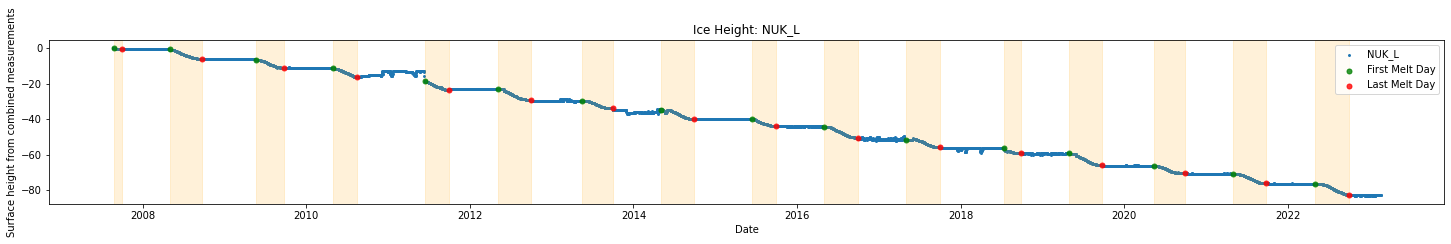

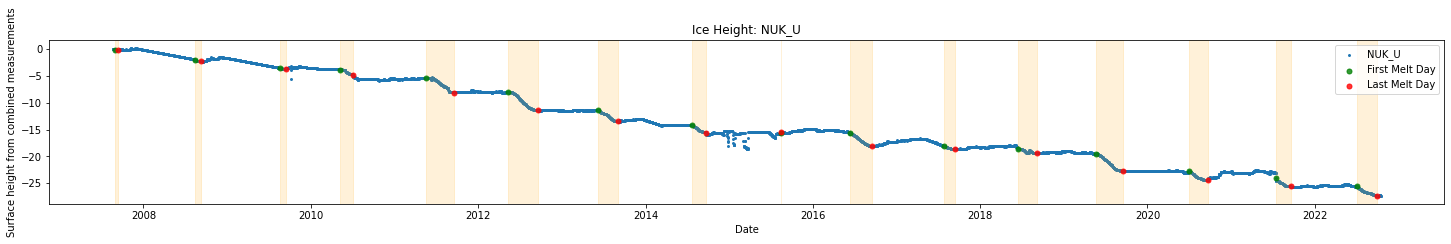

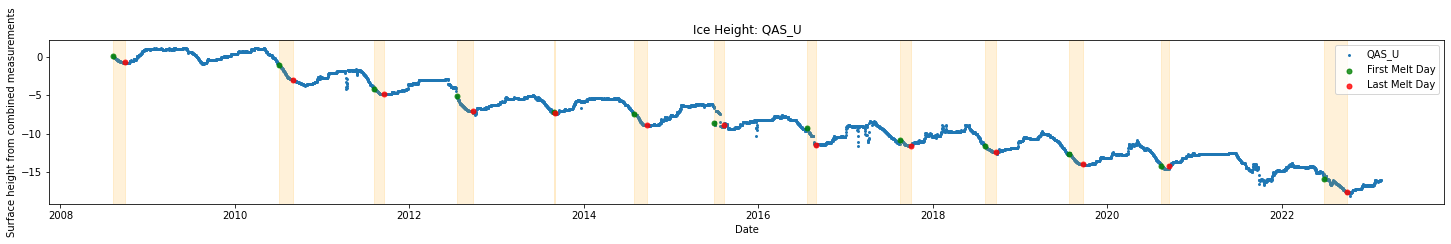

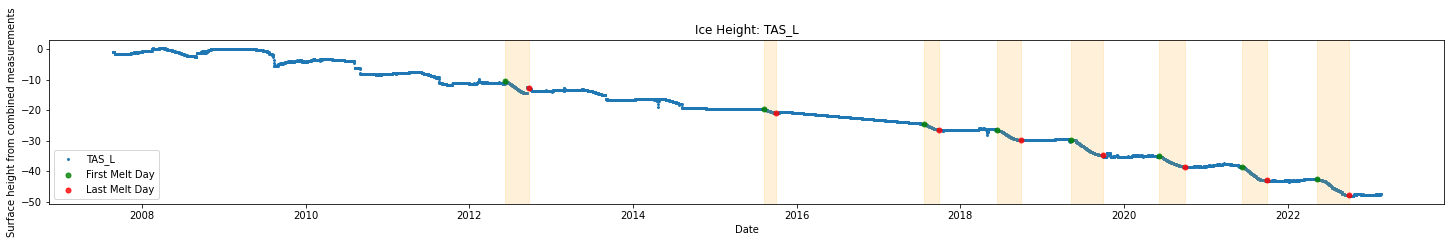

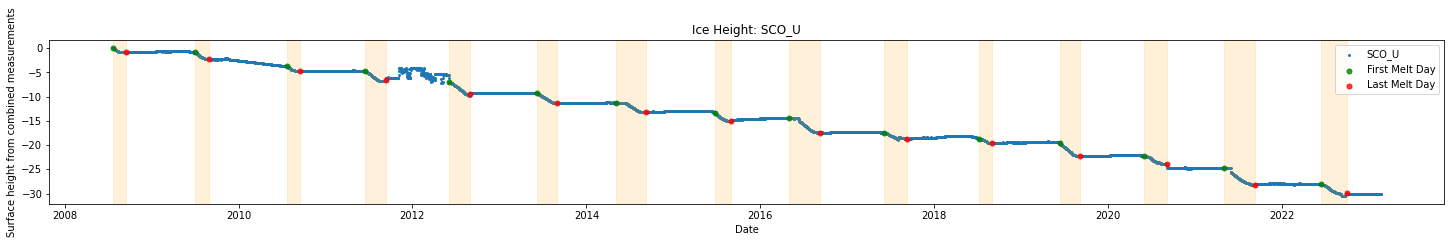

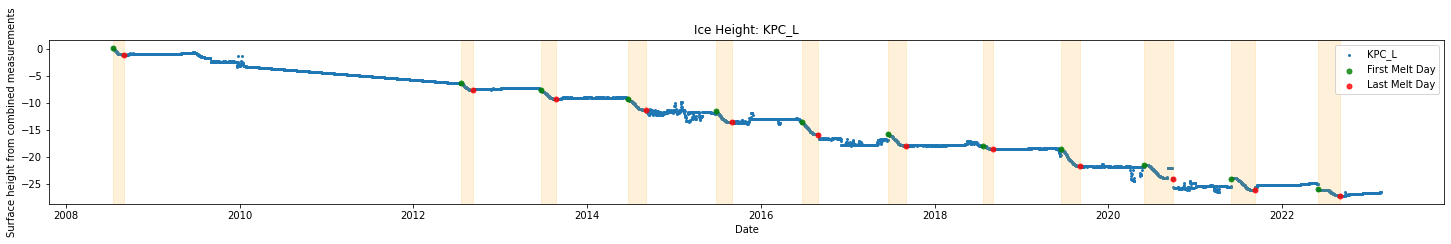

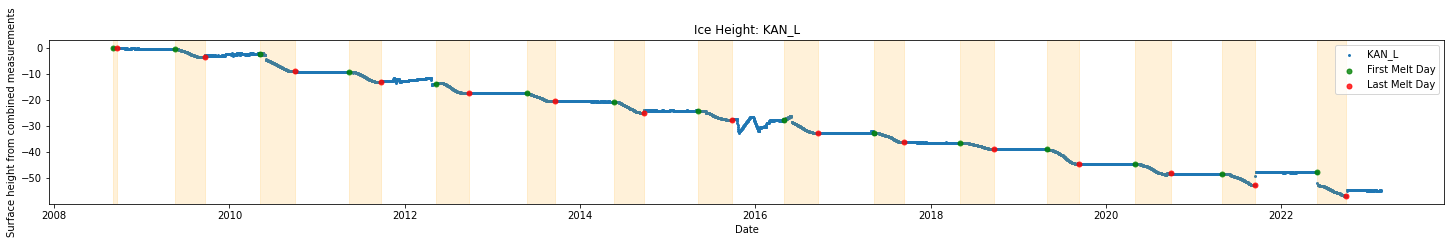

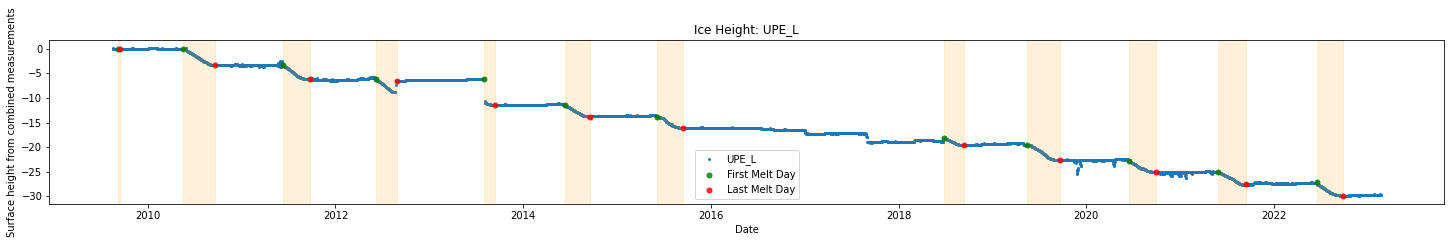

In [9]:
## This bit to visualize all relevant ablation plots


for stid in df['stid'].unique():
    station_df = df[df['stid'] == stid]
    
    # filter the dataframe to only include rows where ablation occurred
    ablation_df = station_df[station_df['Ablation'] == True]

    # create a line plot for each station, highlighting the periods of ablation
    fig, ax = plt.subplots(figsize=(25,3))
    
    # Plot the blue scatter points
    plt.scatter(station_df['Datetime'], station_df['Surface height from combined measurements'], c='C0',  marker='.', label=stid, s=15)
    
    first_melt_days = station_df[station_df['first_melt_day'] == True]['Datetime']
    last_melt_days = station_df[station_df['last_melt_day'] == True]['Datetime']
    
    for first_day, last_day in zip(first_melt_days, last_melt_days):
        ax.axvspan(first_day, last_day, alpha=0.15, color='orange')
    
    # Plot the first melt day values
    plt.scatter(first_melt_days, station_df.loc[first_melt_days.index, 'Surface height from combined measurements'], c='g', alpha=0.8, marker='.', label='First Melt Day', s=100)
    
    # Plot the last melt day values
    plt.scatter(last_melt_days, station_df.loc[last_melt_days.index, 'Surface height from combined measurements'], c='r', alpha=0.8 , marker='.', label='Last Melt Day', s=100)

    # set plot title, axis labels and legend
    ax.set_title(f'Ice Height: {stid}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Surface height from combined measurements')
    ax.legend()
    
    # Save the plot in the Downloads folder
   # plot_filename = f'Surface_Height_{stid}.png'
   # plt.savefig(os.path.join(os.path.expanduser("~"), "Downloads", plot_filename), dpi=300)
    
plt.show()
    

In [6]:
df.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['Unnamed: 0', 'stid', 'Datetime', 'Air pressure (upper boom)',
       'Air temperature (upper boom)',
       'Relative humidity (upper boom) - corrected',
       'Specific humidity (upper boom)', 'Wind speed (upper boom)',
       'Wind from direction (upper boom)',
       'Downwelling shortwave radiation - corrected',
       'Upwelling shortwave radiation - corrected',
       'Downwelling longwave radiation', 'Upwelling longwave radiation',
       'Surface temperature', 'Latent heat flux (upper boom)',
       'Sensible heat flux (upper boom)',
       'Surface height from combined measurements',
       'Surface height from combined measurements DELTA', 'Albedo',
       'Cloud cover', 'Ablation', 'Melting Season', 'Year', 'DayOfYear',
       'first_melt_day', 'last_melt_day'],
      dtype='object')>

## Pre-Processing 0.2 (Target variable Calculation)

In [11]:
# This bit to decompose for each station
df = df[df['Surface height from combined measurements'].notna()] # remove NaN from target

for i in df["stid"].unique().tolist():
    df_station = df[df['stid'] == i]
    if len(df_station) > 730: 
        exec(f"result_{i} = seasonal_decompose(df_station['Surface height from combined measurements'], model='additive', period=365)")
    else:
        print("Station to remove:", i)
        

In [12]:
# This bit to add decomposition to df
ts = pd.DataFrame()

for i in df["stid"].unique().tolist():
    
    # Get data frame for the current station
    df_station = df[df['stid'] == i]

    df_station['observed'] = eval(f"result_{i}.observed")
    df_station['residual'] = eval(f"result_{i}.resid") 
    df_station['seasonal'] = eval(f"result_{i}.seasonal") 
    df_station['trend'] = eval(f"result_{i}.trend")
    df_station['residual_smoothed'] = eval(f"result_{i}.resid") 
    
    # Set the window size and threshold
    window_size = 7
    
    #Outliers based on incremental sum
    threshold_incremental_sum = df_station['residual'].diff().rolling(window_size).sum().quantile(0.8)
    threshold_slope = df_station['residual_smoothed'].diff().abs().quantile(0.8)
        # Calculate the sum of incremental changes over the rolling window
    incremental_sum = df_station['residual'].diff().rolling(window_size).sum()
        # Replace the residuals that exceed the threshold with NaN
    df_station['residual_smoothed'] = df_station['residual']
    df_station.loc[incremental_sum > threshold_incremental_sum, 'residual_smoothed'] = np.nan

    # Outliers based on slope
    slope = df_station['residual_smoothed'].diff().abs()
        # Calculate the 80th percentile of the slopes
    threshold_slope = slope.quantile(0.8)
        # Remove values where the slope is steeper than the threshold
    df_station.loc[slope > threshold_slope, 'residual_smoothed'] = np.nan

    # fill in the NaN values with linear interpolation
    #df_station['residual_smoothed'].interpolate(method='linear', inplace=True)

    # Add new column for seasonal residual
    df_station['seasonal_residual'] = df_station['residual'].fillna(0) + df_station['seasonal']
    
    # Add column for current station
    df_station['stid'] = i
    
    # Append to time series data frame
    ts = ts.append(df_station[['Datetime', 'stid', 'observed', 'residual', 'seasonal', 'trend', 'residual_smoothed', 'seasonal_residual']])

# Merge time series data frame with original data frame
df = pd.merge(df, ts, on=['Datetime', 'stid'], how='left')


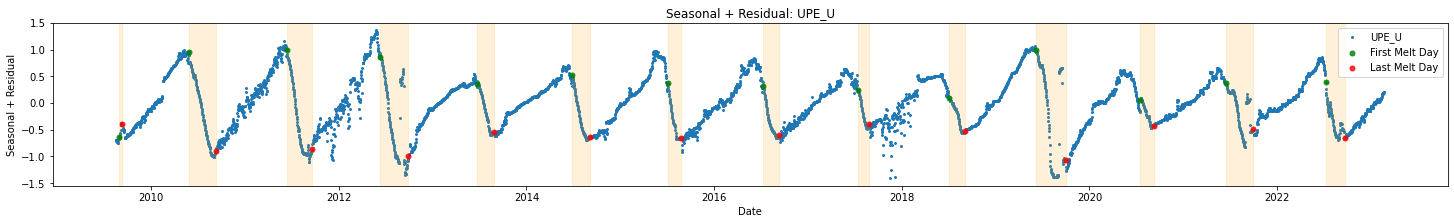

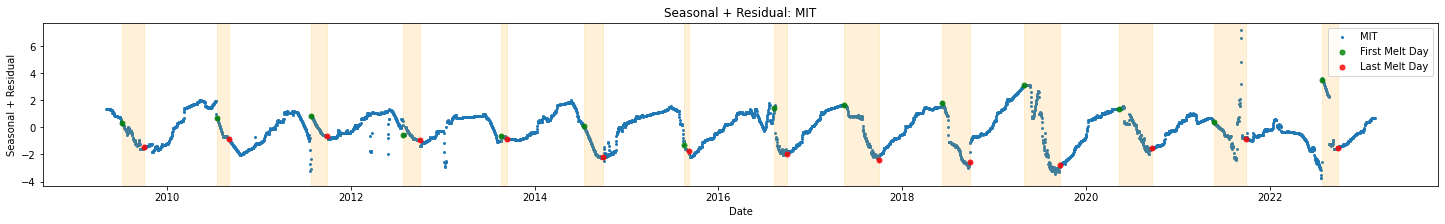

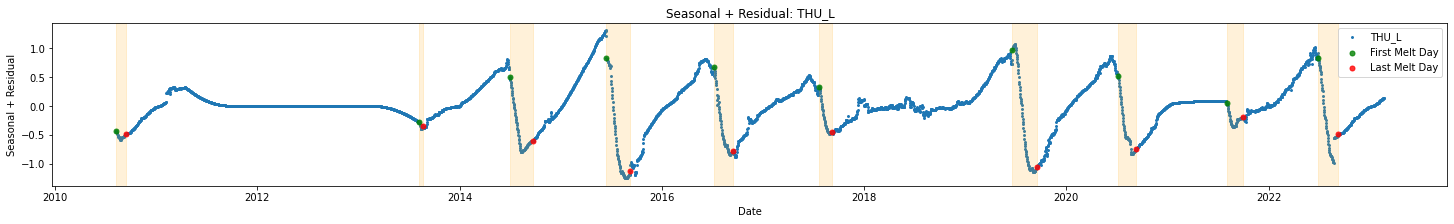

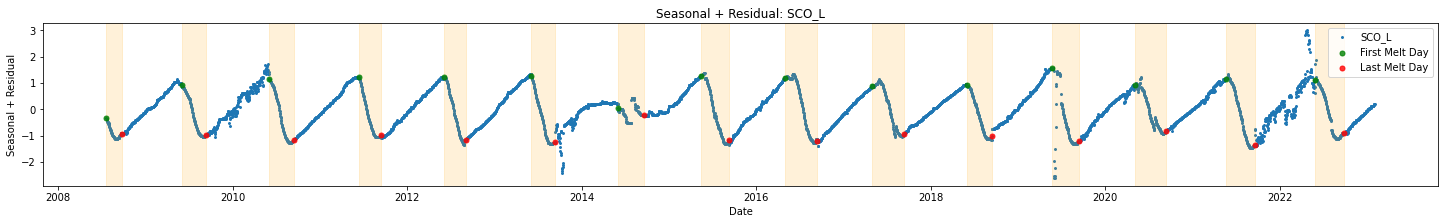

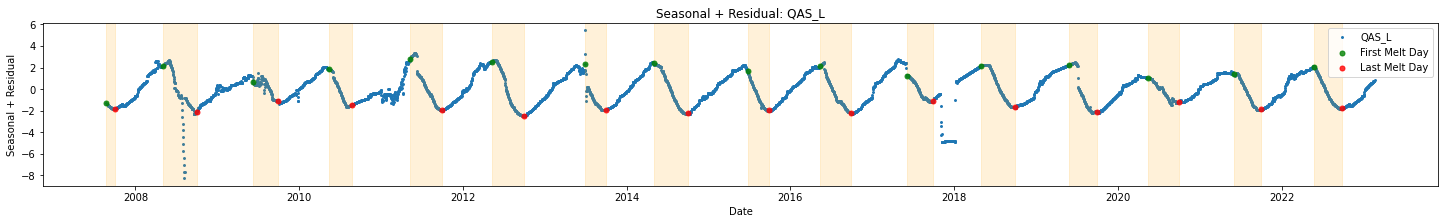

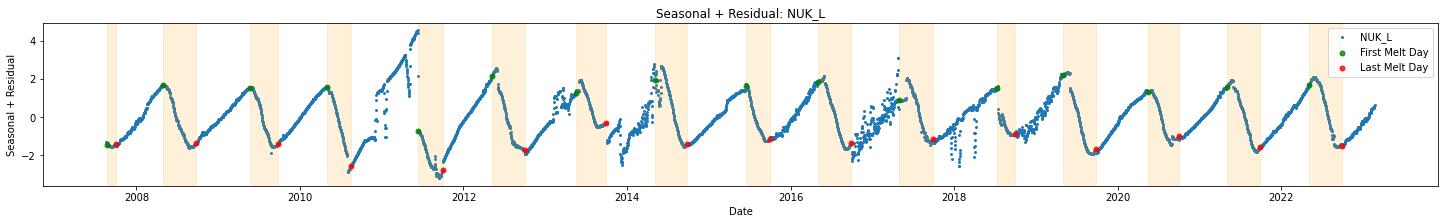

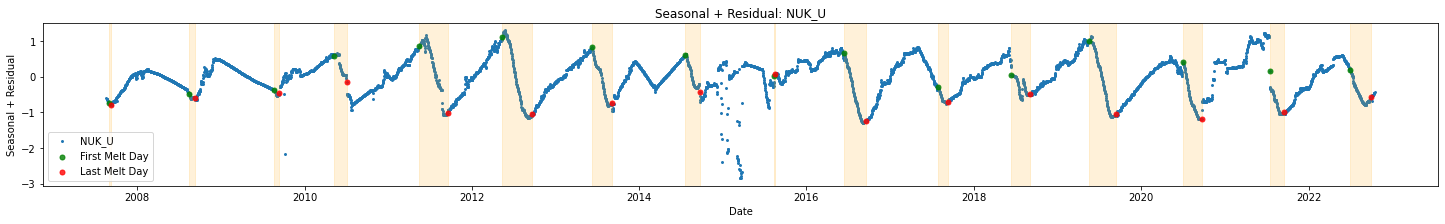

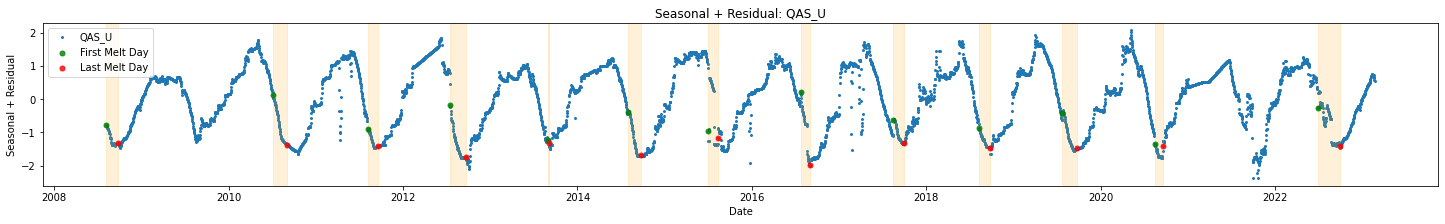

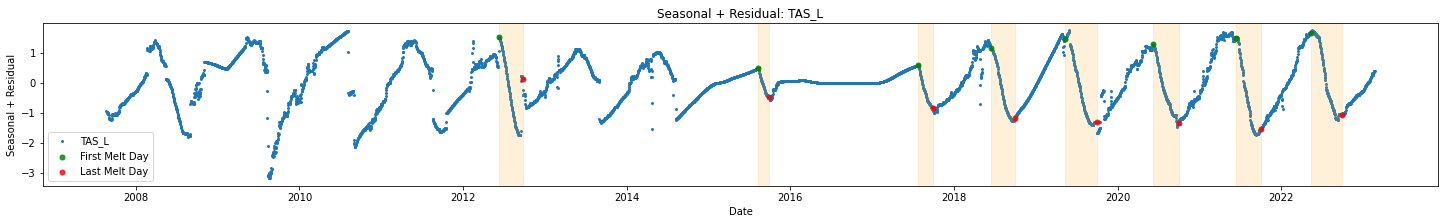

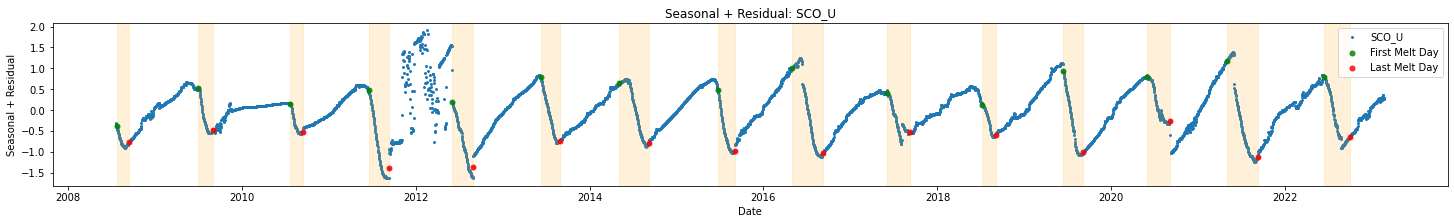

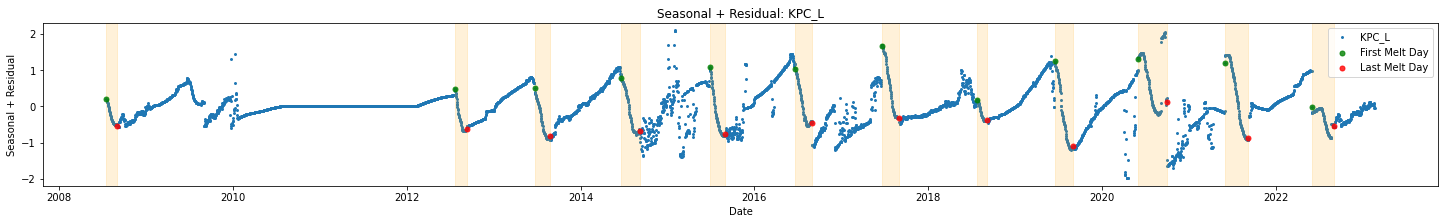

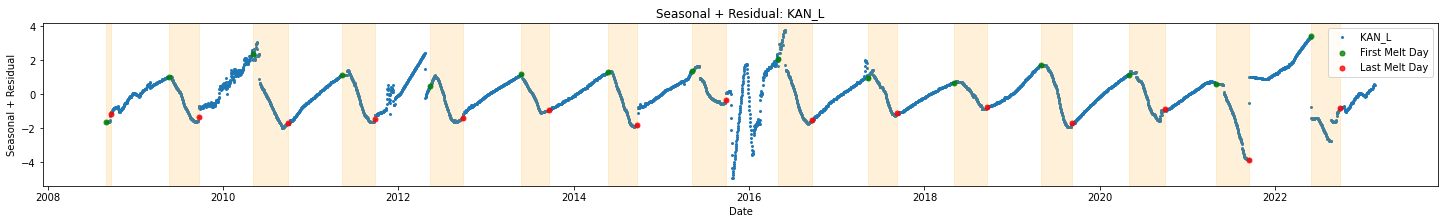

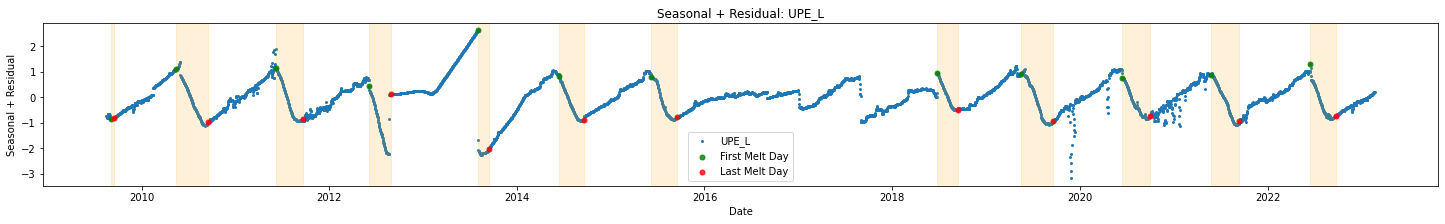

In [13]:
## Plot seasonal_residual for all stations

for stid in df['stid'].unique():
    station_df = df[df['stid'] == stid]
    # filter the dataframe to only include rows where ablation occurred
    ablation_df = df[df['Ablation'] == True]

    # create a line plot for each station, highlighting the periods of ablation
    fig, ax = plt.subplots(figsize=(25,3))

    
    # Plot the blue scatter points
    plt.scatter(station_df['Datetime'], station_df['seasonal_residual'], c='C0',  marker='.', label=stid, s=15)
    
    first_melt_days = station_df[station_df['first_melt_day'] == True]['Datetime']
    last_melt_days = station_df[station_df['last_melt_day'] == True]['Datetime']
    
    for first_day, last_day in zip(first_melt_days, last_melt_days):
        ax.axvspan(first_day, last_day, alpha=0.15, color='orange')
    
    # Plot the first melt day values
    plt.scatter(first_melt_days, station_df.loc[first_melt_days.index, 'seasonal_residual'], c='g', alpha=0.8, marker='.', label='First Melt Day', s=100)
    
    # Plot the last melt day values
    plt.scatter(last_melt_days, station_df.loc[last_melt_days.index, 'seasonal_residual'], c='r', alpha=0.8 , marker='.', label='Last Melt Day', s=100)

    # set plot title, axis labels and legend
    ax.set_title(f'Seasonal + Residual: {stid}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Seasonal + Residual')
    ax.legend()
    
    # Save the plot in the Downloads folder
   # plot_filename = f'seasonal_residual_{stid}.png'
   # plt.savefig(os.path.join(os.path.expanduser("~"), "Downloads", plot_filename), dpi=300)
    
    
plt.show()


## Pre-Processing 1.0

##### Set target variable

In [14]:
y = 'seasonal_residual'

##### Change wind from direction to cycle

In [15]:
# This bit to change the datetime variables into a form that a ML models can understand
  # https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
  # https://feature-engine.trainindata.com/en/1.3.x/user_guide/creation/CyclicalFeatures.html
    
    
# This bit to split Datetime column into year, month, day, hour columns
df["Datetime"] = pd.to_datetime(df["Datetime"], format="%Y-%m-%d")

#Create new columns
df['year'] = df['Datetime'].dt.year 
df['month'] = df['Datetime'].dt.month
df['day'] = df['Datetime'].dt.day

In [16]:
# Use CyclicalFeatures Package to convert year, month, day & hour

cyclical = CyclicalFeatures(variables=None, drop_original=True)

# Remove only values from Wind direction because CyclicalFeatures does not work with NA values
df_wind = df[df['Wind from direction (upper boom)'].notna()] 
cyclical_df = cyclical.fit_transform(df_wind[['Wind from direction (upper boom)']]) 

# Reset the index for cyclical_df
cyclical_df.reset_index(inplace=True)

# Merge the original df with the cyclical_df using a left join
df = pd.merge(df.reset_index(), cyclical_df, left_on='index', right_on='index', how='left')

##### Filter relevant periods

In [18]:
df = df[df[y].notna()] # Remove NaN from target

In [19]:
## This bit to filter by the +- 10 days around melt onset/ melt end

# Convert your Datetime column to datetime
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Extract year from the Datetime column
df['year'] = df['Datetime'].dt.year

start_day_first = 10
end_day_first = 10
start_day_last = 10
end_day_last = 10

# Define a custom function to filter rows based on the conditions
def filter_melt_days(group):
    first_melt_day = group[group['first_melt_day'] == True]['Datetime'].min()
    last_melt_day = group[group['last_melt_day'] == True]['Datetime'].max()

    start_date = first_melt_day - pd.Timedelta(days=start_day_first)
    end_date = last_melt_day + pd.Timedelta(days=end_day_last)

    return group[(group['Datetime'] >= start_date) & (group['Datetime'] <= end_date)]

# Apply the custom function to each group of 'stid' and 'year' and concatenate the results
df = df.groupby(['stid', 'year']).apply(filter_melt_days).reset_index(drop=True)

for category in [True]:
    exec(f"indices_first_melt_day= df[df['first_melt_day'] == {category}].index")
for category in [True]:
    exec(f"indices_last_melt_day= df[df['last_melt_day'] == {category}].index")
    
# Define a custom function to extract the expanded indices from the filtered DataFrame
def extract_expanded_indices(filtered_df):
    expanded_indices_first = []
    expanded_indices_last = []

    for (stid, year), group in filtered_df.groupby(['stid', 'year']):
        first_melt_day = group[group['first_melt_day'] == True]['Datetime'].min()
        last_melt_day = group[group['last_melt_day'] == True]['Datetime'].max()

        start_date_first = first_melt_day - pd.Timedelta(days=start_day_first)
        end_date_first = first_melt_day + pd.Timedelta(days=end_day_first)

        start_date_last = last_melt_day - pd.Timedelta(days=start_day_last)
        end_date_last = last_melt_day + pd.Timedelta(days=end_day_last)

        expanded_first = group[(group['Datetime'] >= start_date_first) & (group['Datetime'] <= end_date_first)].index
        expanded_last = group[(group['Datetime'] >= start_date_last) & (group['Datetime'] <= end_date_last)].index

        expanded_indices_first.extend(expanded_first)
        expanded_indices_last.extend(expanded_last)

    return expanded_indices_first, expanded_indices_last

# Extract the expanded indices for first and last melt days
expanded_indices_first, expanded_indices_last = extract_expanded_indices(df)


In [21]:
# This bit retrieve the indexes for all melting season categories (used later in SHAP)

# Fill NA values in Melting season as blank
df['Melting Season'] = df['Melting Season'].fillna('no_ablation')

for category in ['pre', 'beginning', 'middle', 'end', 'no_ablation']:
    exec(f"indices_{category} = df[df['Melting Season'] == '{category}'].index")

# This bit retrieve the indexes for Ablation periods
for category in [True]:
    exec(f"indices_ablation = df[df['Ablation'] == {category}].index")

indices_all = df[df['Ablation'].isin([True, False])].index
    
for category in [True]:
    exec(f"indices_first_melt_day= df[df['first_melt_day'] == {category}].index")
for category in [True]:
    exec(f"indices_last_melt_day= df[df['last_melt_day'] == {category}].index")
  

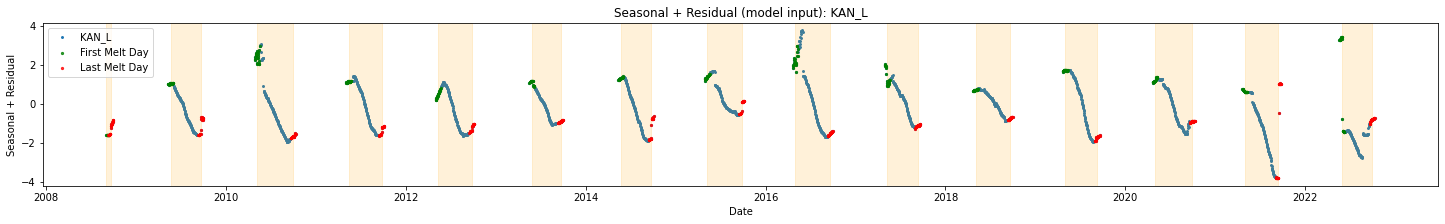

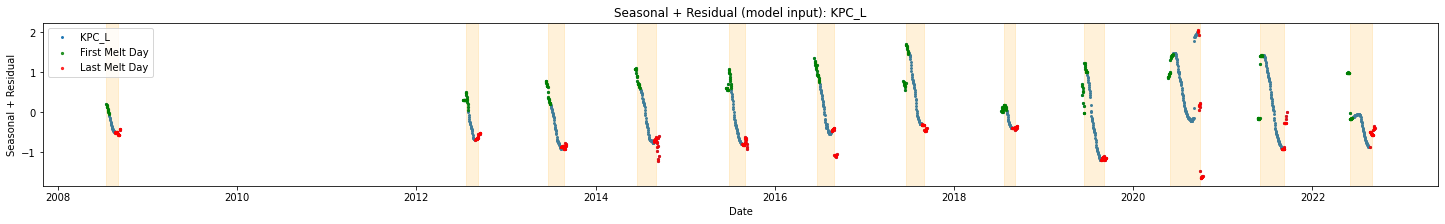

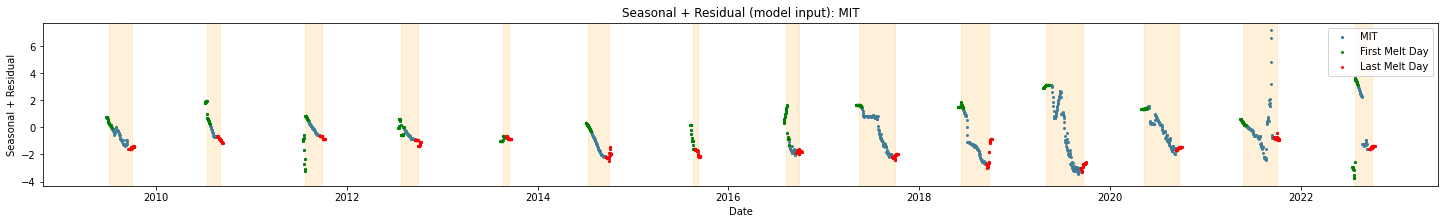

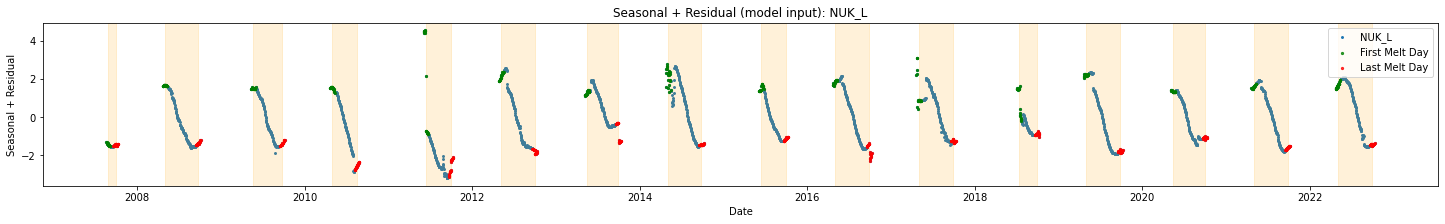

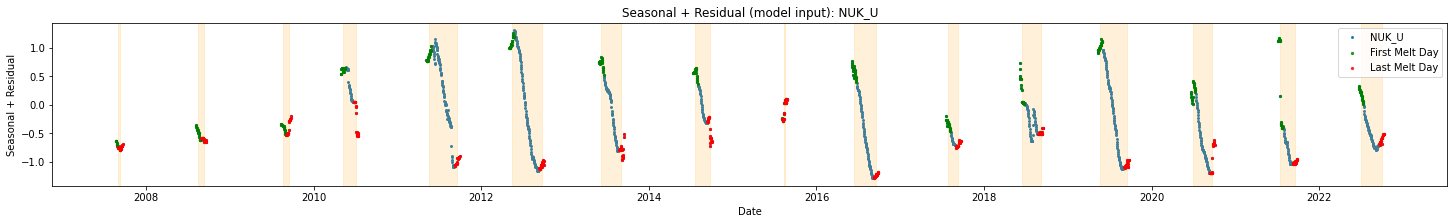

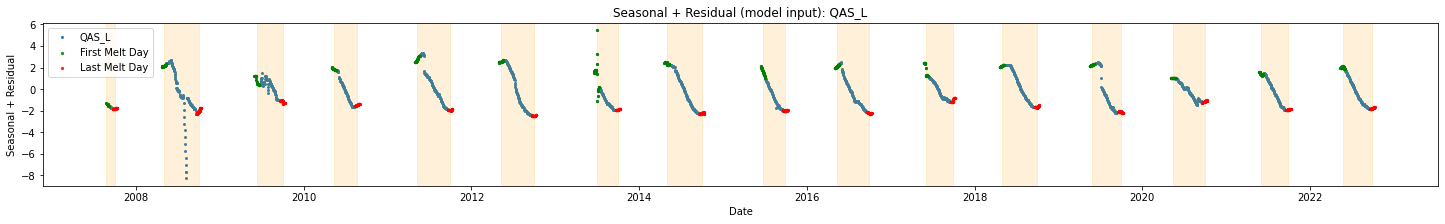

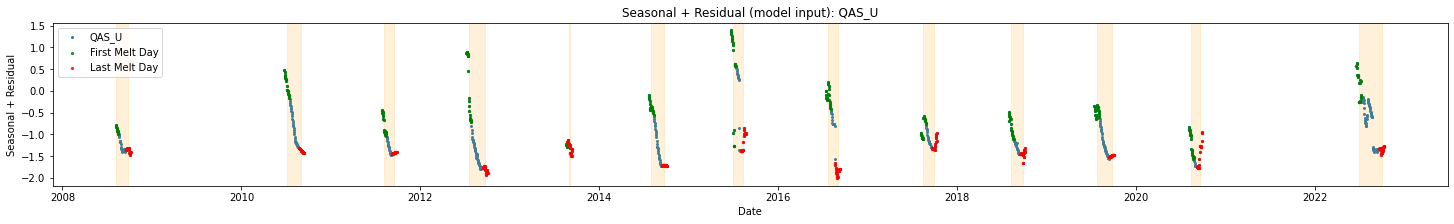

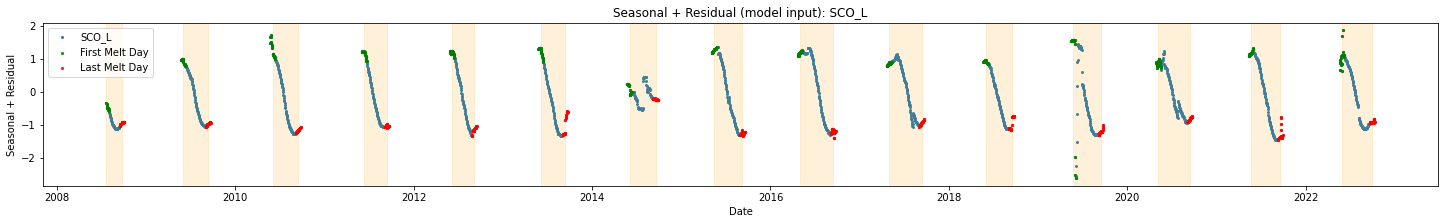

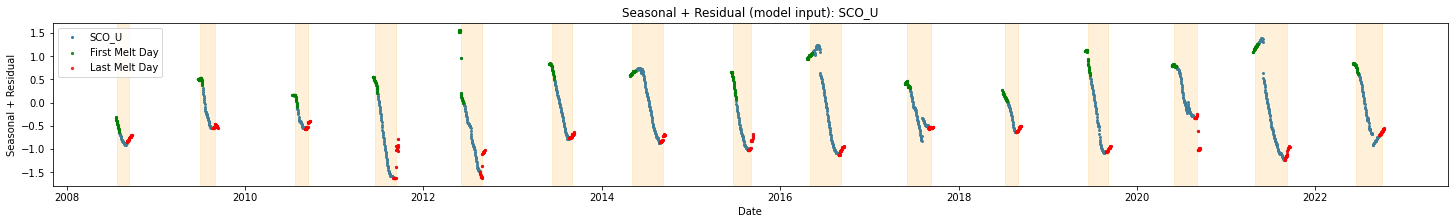

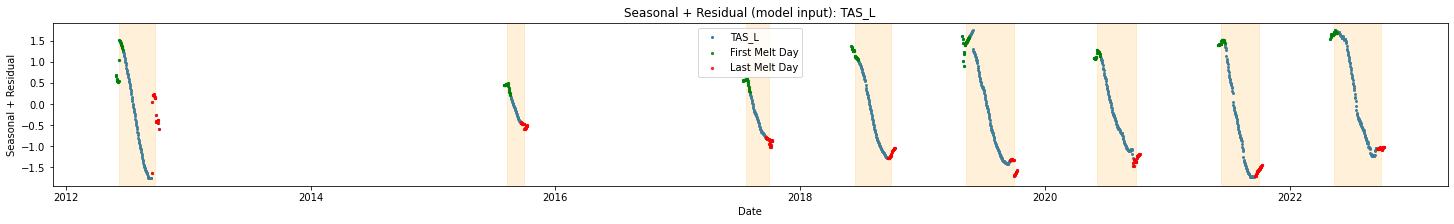

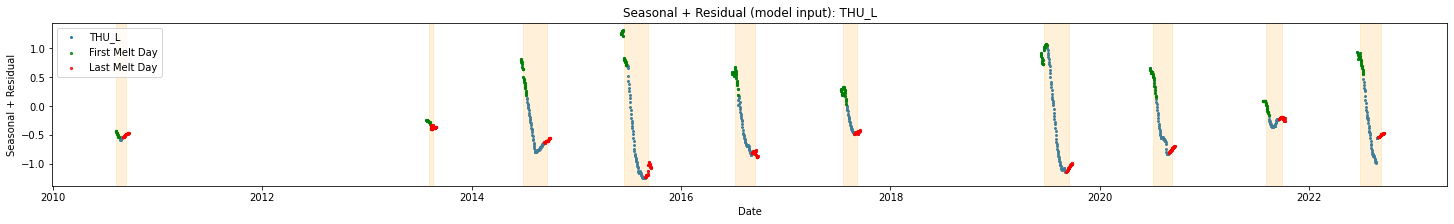

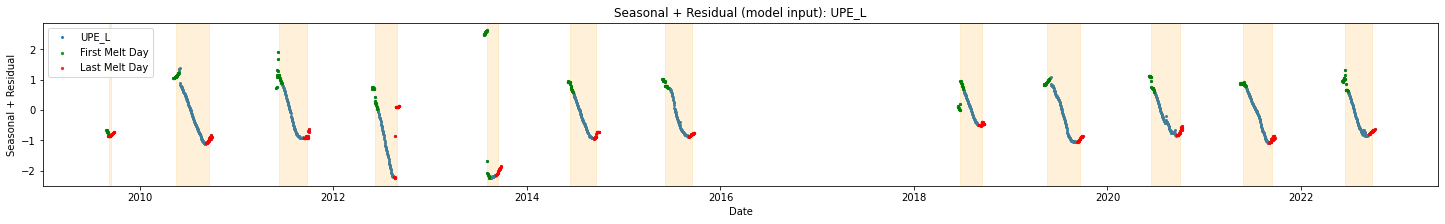

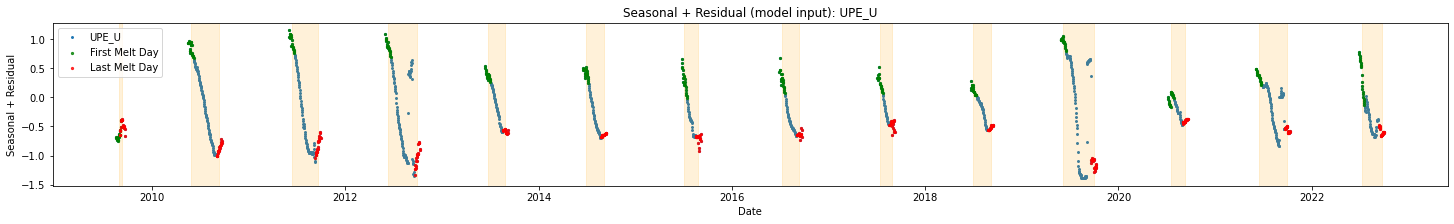

In [22]:
## Plot all stations and the filtred periods

for stid in df['stid'].unique():
    station_df = df[df['stid'] == stid]
    # filter the dataframe to only include rows where ablation occurred
   # ablation_df = df[df['Ablation'] == True]

    # create a line plot for each station, highlighting the periods of ablation
    fig, ax = plt.subplots(figsize=(25,3))
    station_df = df[df['stid'] == stid]
    
    # Plot the blue scatter points
    plt.scatter(station_df['Datetime'], station_df['seasonal_residual'], c='C0',  marker='.', label=stid, s=15)
    
    first_melt_days = station_df[station_df['first_melt_day'] == True]['Datetime']
    last_melt_days = station_df[station_df['last_melt_day'] == True]['Datetime']
    
    for first_day, last_day in zip(first_melt_days, last_melt_days):
        ax.axvspan(first_day, last_day, alpha=0.15, color='orange')
    
    first_melt_days = station_df[station_df.index.isin(expanded_indices_first)]
    last_melt_days = station_df[station_df.index.isin(expanded_indices_last)]
    
    # Plot the first melt day values
    #plt.scatter(first_melt_days, station_df.loc[first_melt_days.index, 'seasonal_residual'], c='g', alpha=0.8, marker='.', label='First Melt Day', s=100)
    plt.scatter(first_melt_days['Datetime'], station_df.loc[first_melt_days.index, 'seasonal_residual'], c='g', alpha=0.8, marker='.', label='First Melt Day', s=20)
    
    # Plot the last melt day values
    #plt.scatter(last_melt_days, station_df.loc[last_melt_days.index, 'seasonal_residual'], c='r', alpha=0.8 , marker='.', label='Last Melt Day', s=100)
    plt.scatter(last_melt_days['Datetime'], station_df.loc[last_melt_days.index, 'seasonal_residual'],c='r', alpha=0.8 , marker='.', label='Last Melt Day', s=20)
    
    # set plot title, axis labels and legend
    ax.set_title(f'Seasonal + Residual (model input): {stid}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Seasonal + Residual')
    ax.legend()
    
    # Save the plot in the Downloads folder
    #plot_filename = f'seasonal_residual_model_{stid}.png'
    #plt.savefig(os.path.join(os.path.expanduser("~"), "Downloads", plot_filename), dpi=300)
    
plt.show()


##### Formatting and transformation

In [25]:
## This bit to label encode stations
 
# Creating a instance of label Encoder.
le = LabelEncoder()
 
# Using .fit_transform function to fit label
# encoder and return encoded label
df['stid'] = le.fit_transform(df['stid'])
station_names = dict(zip(le.classes_, le.transform(le.classes_)))

In [50]:
# This bit to include only relevant features
exclude_list = ['index', # excluded because of unimportant information
                #'stid', 
                'Unnamed: 0', # Old Index
                'ID',
                'Wind from direction (upper boom)',
                'Ablation',
                'Melting Season', # We drop melting season later 
                'month',
                'month_sin',
                'month_cos',
                'day', 
                'day_sin',
                'day_cos',
                'hour', 
                'year',
                'year_sin',
                'year_cos'
                'subgroup',
                'Surface height from combined measurements',
                'Surface height from combined measurements DELTA',
                'observed', 
                'residual', 
                'seasonal', 
                'trend',
                'residual_smoothed',
                'Periods',
                'Year',
                'first_melt_day',
                'last_melt_day',
                'DayOfYear',
                'Datetime',
                'day_of_year',
                #'seasonal_residual'
               ]



df = df[[column for column in df.columns if column not in exclude_list]]
data = df.copy()

In [51]:
# This bit to convert all numerical values into the same scale 
scalers = [StandardScaler(), MinMaxScaler(), RobustScaler()]

# Exclude whater is not needed for scaling
exlude_num = ['stid', 
              'Surface height from combined measurements', 
              'Surface height from combined measurements DELTA',
              'month_sin',
              'month_cos',
              'month',
              'day', 
              'day_sin',
              'day_cos',
              'hour', 
              'year',
              'year_sin',
              'year_cos'
              'subgroup',
              'Surface height from combined measurements',
              'Surface height from combined measurements DELTA',
              'observed', 
              'residual', 
              'seasonal', 
              'trend',
              'Wind from direction (upper boom)',
              'Wind from direction (upper boom)_sin',
              'Wind from direction (upper boom)_cos',
              'seasonal_residual',
              'residual_smoothed',
              'Datetime',
             ]


num_cols = df.select_dtypes(include=['int64','float64'])
num_cols = num_cols[[column for column in num_cols.columns if column not in exlude_num]].columns

scaler = MinMaxScaler()

#fit and transform numerical columns
df[num_cols] = scaler.fit_transform(df[num_cols])
data[num_cols] = scaler.fit_transform(data[num_cols])

df['seasonal_residual'] = scaler.fit_transform(df['seasonal_residual'].values.reshape(-1, 1))
data['seasonal_residual'] = scaler.fit_transform(data['seasonal_residual'].values.reshape(-1, 1))

In [52]:
## This bit only for baseline models (albedo imputation and NaN removal)
df_base = df
print(df_base['Albedo'].isna().sum())
df_base['Albedo'] = df_base['Albedo'].fillna(method='bfill')
print(df_base.isna().sum())
df_base = df_base.dropna()

from sklearn.model_selection import train_test_split

# Get unique stid values
stid_values = df_base['stid'].unique()

# Initialize empty lists to store train and test data
X_train, X_test, y_train, y_test = [], [], [], []

# Loop through each stid value and split the data into train and test sets
for stid in stid_values:
    # Get rows corresponding to the current stid value
    subset_df_base = df_base[df_base['stid'] == stid]
    
    # Split the subset into train and test sets
    X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(
        subset_df_base.drop([y], axis=1), subset_df_base[y], test_size=0.3, random_state=123, shuffle =True)
    
    # Append the train and test data to the lists
    X_train.append(X_train_subset)
    X_test.append(X_test_subset)
    y_train.append(y_train_subset)
    y_test.append(y_test_subset)

# Concatenate the train and test data into a single dataframe
X_train_base = pd.concat(X_train)
X_test_base = pd.concat(X_test)
y_train_base = pd.concat(y_train)
y_test_base = pd.concat(y_test)

25
stid                                              0
Air pressure (upper boom)                       293
Air temperature (upper boom)                    298
Relative humidity (upper boom) - corrected      430
Specific humidity (upper boom)                 1273
Wind speed (upper boom)                        1155
Downwelling shortwave radiation - corrected    1643
Upwelling shortwave radiation - corrected      1643
Downwelling longwave radiation                 1039
Upwelling longwave radiation                    991
Surface temperature                            1071
Latent heat flux (upper boom)                  3222
Sensible heat flux (upper boom)                3222
Albedo                                           25
Cloud cover                                    1071
seasonal_residual                                 0
Wind from direction (upper boom)_sin           1155
Wind from direction (upper boom)_cos           1155
dtype: int64


In [53]:
# Get unique stid values
stid_values = df['stid'].unique()

# Initialize empty lists to store train and test data
X_train, X_test, y_train, y_test = [], [], [], []

# Loop through each stid value and split the data into train and test sets
for stid in stid_values:
    # Get rows corresponding to the current stid value
    subset_df = df[df['stid'] == stid]
    
    # Split the subset into train and test sets
    X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(
        subset_df.drop([y], axis=1), subset_df[y], test_size=0.3, random_state=123, shuffle =True)
    
    # Append the train and test data to the lists
    X_train.append(X_train_subset)
    X_test.append(X_test_subset)
    y_train.append(y_train_subset)
    y_test.append(y_test_subset)

# Concatenate the train and test data into a single dataframe
X_train = pd.concat(X_train)
X_test = pd.concat(X_test)
y_train = pd.concat(y_train)
y_test = pd.concat(y_test)

In [54]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=42)

In [55]:
def plot_cv_indices(cv, X, y, ax, n_splits, lw=10):
    for ii, (tr, tt) in enumerate(cv.split(X, y)):
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        ax.scatter(range(len(indices)), [ii + 0.5] * len(indices), c=indices, marker="_", lw=lw, cmap=plt.cm.coolwarm, vmin=-0.2, vmax=1.2)

    ax.set_xlabel("Sample index")
    ax.set_ylabel("CV iteration")
    ax.set_yticks(np.arange(n_splits) + 0.5)
    ax.set_yticklabels(list(range(n_splits)))
    ax.set_title("{}".format(type(cv).__name__))
    return ax

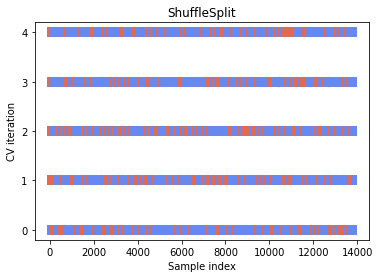

In [56]:
fig, ax = plt.subplots()
plot_cv_indices(cv, X_train, y_train, ax, cv.get_n_splits(X_train, y_train))
plt.show()

## Regression Modelling

In [36]:
from sklearn.metrics import mean_squared_error
from sklearn.experimental import enable_hist_gradient_boosting  # Required to enable HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
import xgboost as xgb

In [57]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=cv, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("R^2")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, shuffle = True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt


In [58]:
def plot_validation_curve(estimator, title, X, y, param_name, param_range, cv=None, n_jobs=-1, log_scale=False):
    train_scores, test_scores = validation_curve(estimator, X, y, param_name=param_name, param_range=param_range, cv=cv, n_jobs=n_jobs)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title(title)
    plt.xlabel(f"{param_name}")
    plt.ylabel("Score")
    plt.grid()

    if log_scale:
        plt.xscale("log")

    plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(param_range, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(param_range, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best hyperparameters: {'fit_intercept': True}
Average R^2 test score from cv : 0.41024128272024674
Standard deviation of R^2 test scores from cv: 0.005326491147694097


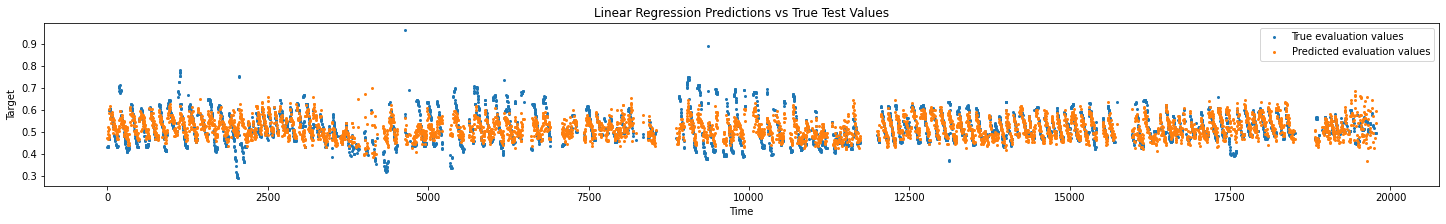

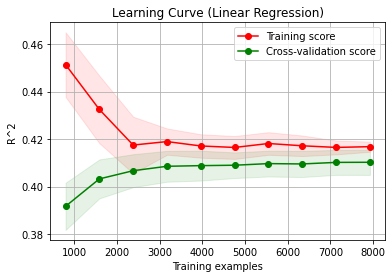

------------------------------------------------------------------------------------
R^2 score on validation set (seasonal_residual):  0.4103935024873544
MSE on validation set (seasonal_residual):  0.0029247711729666285
------------------------------------------------------------------------------------
KAN_L
R^2 score on test set (seasonal_residual):  0.37301153458436953
MSE on test set (seasonal_residual):  0.004333444400729761


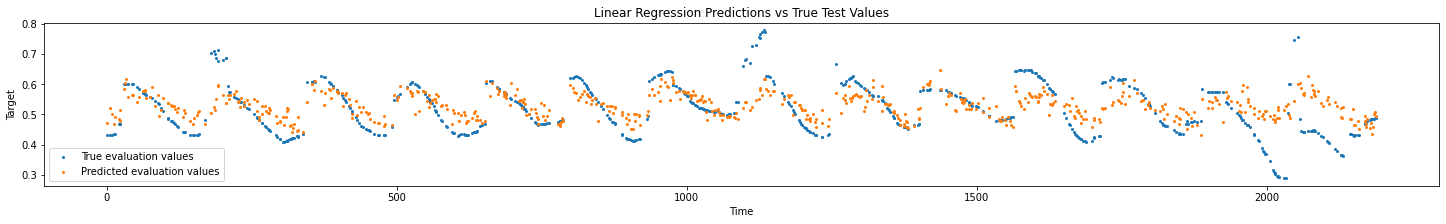

------------------------------------------------------------------------------------
KPC_L
R^2 score on test set (seasonal_residual):  0.2678127553374867
MSE on test set (seasonal_residual):  0.0017575985616392477


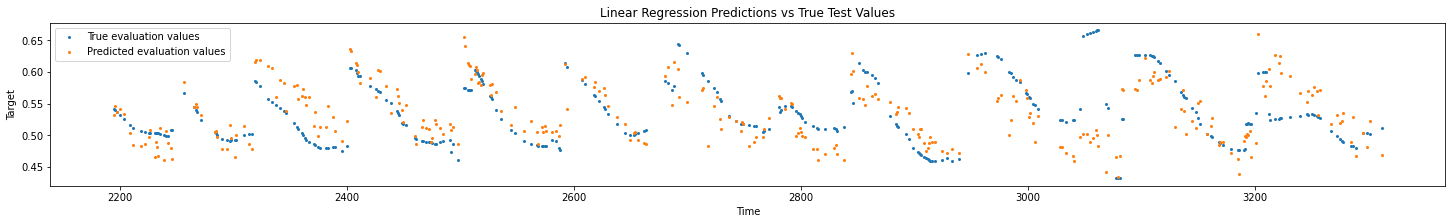

------------------------------------------------------------------------------------
MIT
R^2 score on test set (seasonal_residual):  0.07481644952911204
MSE on test set (seasonal_residual):  0.005041771709523361


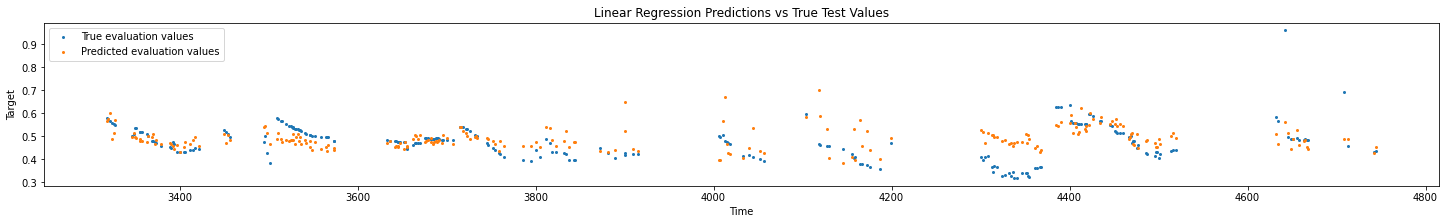

------------------------------------------------------------------------------------
NUK_L
R^2 score on test set (seasonal_residual):  0.3499972771075073
MSE on test set (seasonal_residual):  0.004782405534306196


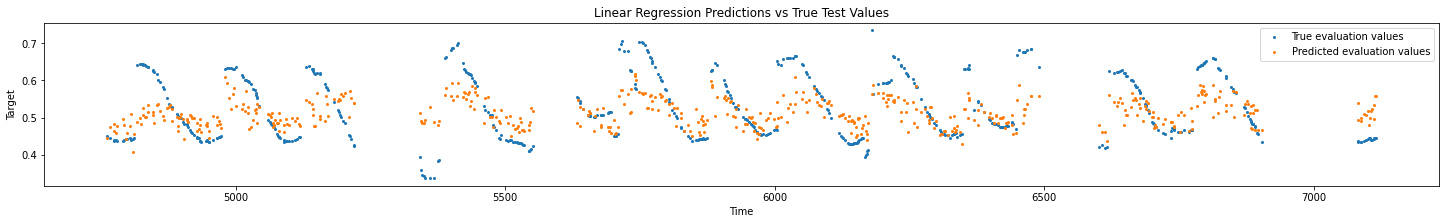

------------------------------------------------------------------------------------
NUK_U
R^2 score on test set (seasonal_residual):  0.27859109552805894
MSE on test set (seasonal_residual):  0.0011799932753444764


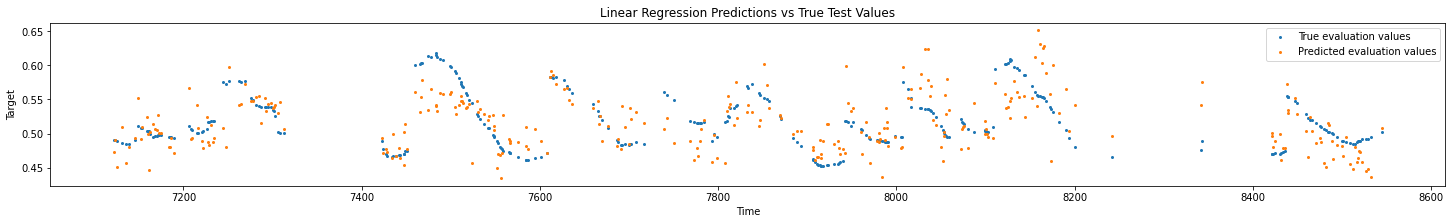

------------------------------------------------------------------------------------
QAS_L
R^2 score on test set (seasonal_residual):  0.4663656973383824
MSE on test set (seasonal_residual):  0.0064832676864301575


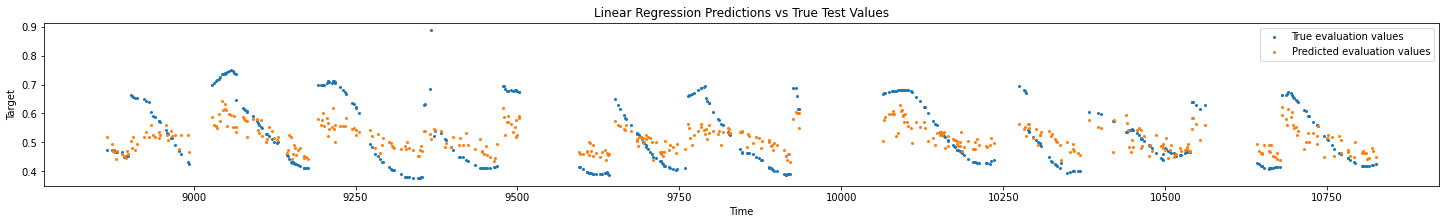

------------------------------------------------------------------------------------
QAS_U
R^2 score on test set (seasonal_residual):  -0.27387327275962425
MSE on test set (seasonal_residual):  0.0020012128332597737


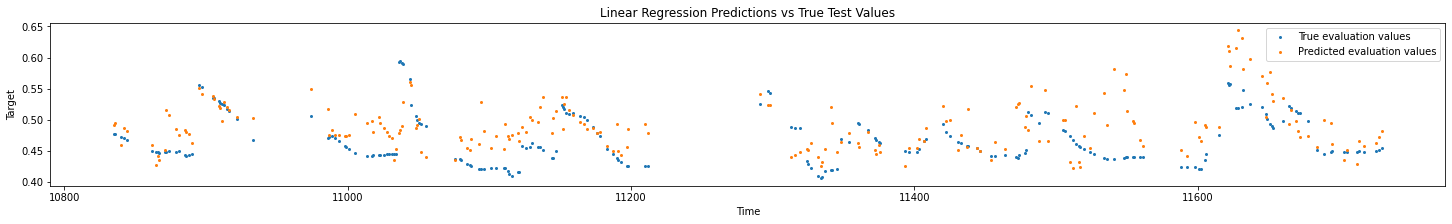

------------------------------------------------------------------------------------
SCO_L
R^2 score on test set (seasonal_residual):  0.6546840143105167
MSE on test set (seasonal_residual):  0.0012865301673459831


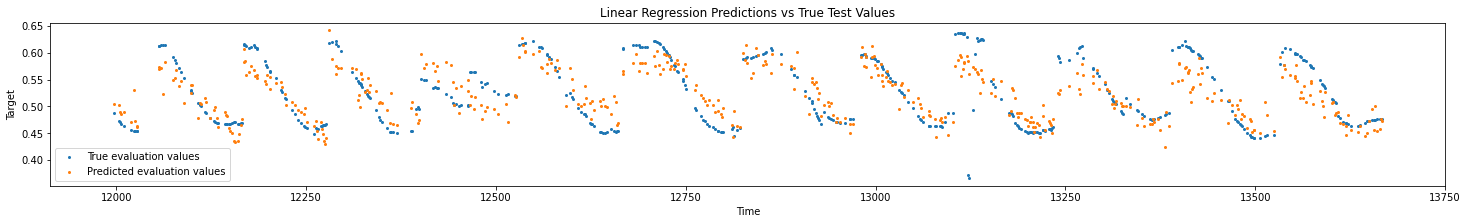

------------------------------------------------------------------------------------
SCO_U
R^2 score on test set (seasonal_residual):  0.6136888837734036
MSE on test set (seasonal_residual):  0.0007879020399163991


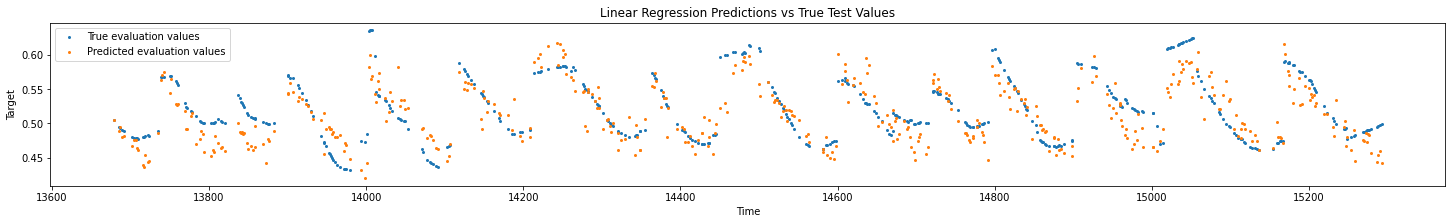

------------------------------------------------------------------------------------
TAS_L
R^2 score on test set (seasonal_residual):  0.5701387478312263
MSE on test set (seasonal_residual):  0.00190446723714354


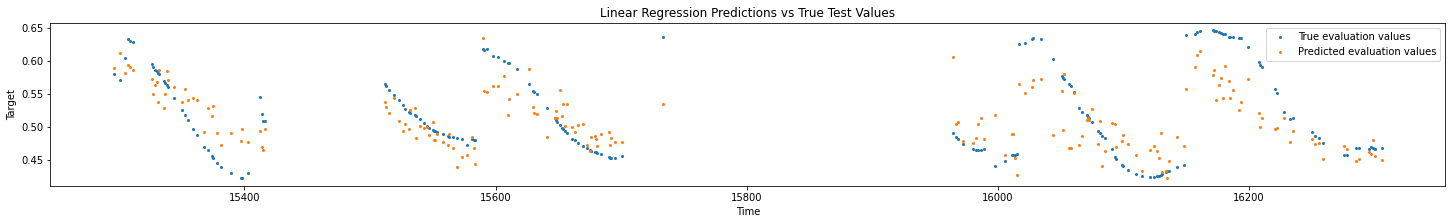

------------------------------------------------------------------------------------
THU_L
R^2 score on test set (seasonal_residual):  0.41047116901862457
MSE on test set (seasonal_residual):  0.0009398796723522899


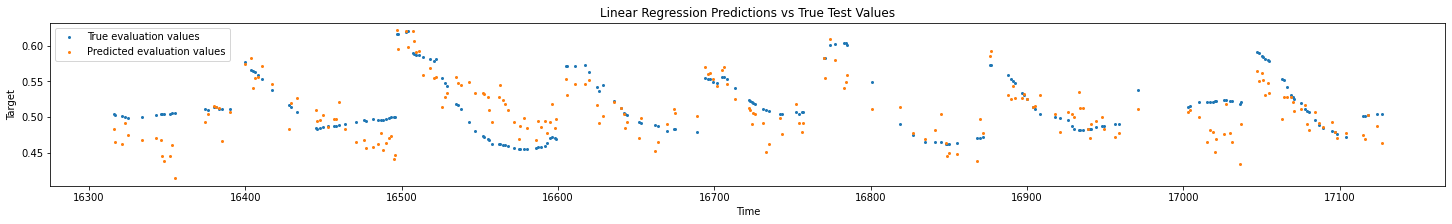

------------------------------------------------------------------------------------
UPE_L
R^2 score on test set (seasonal_residual):  0.34791826260299685
MSE on test set (seasonal_residual):  0.0017874871238054845


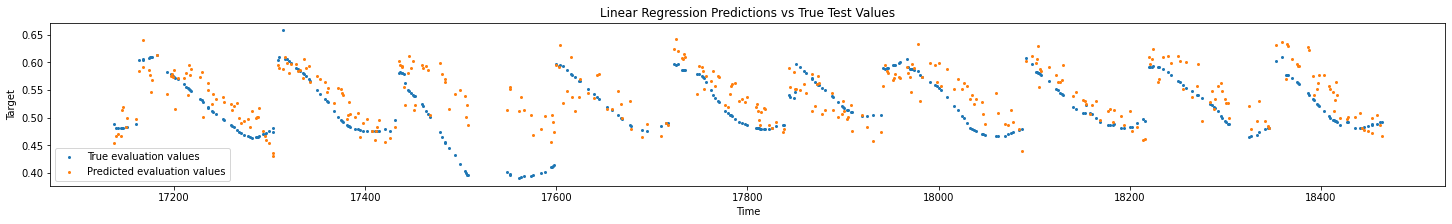

------------------------------------------------------------------------------------
UPE_U
R^2 score on test set (seasonal_residual):  -1.2889203262096833
MSE on test set (seasonal_residual):  0.0026711420777989344


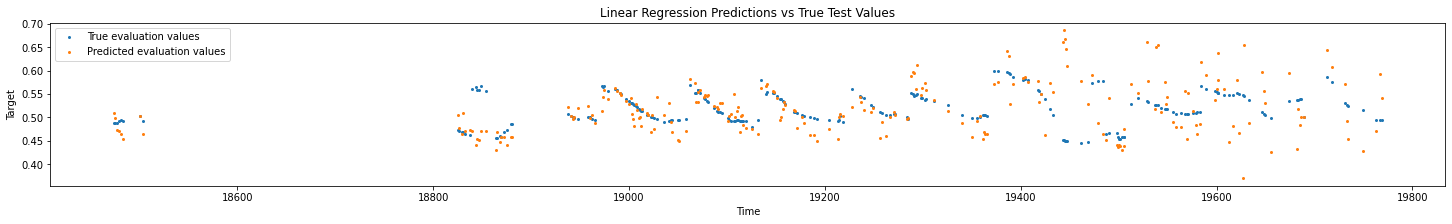

In [59]:
# Create the Linear Regression Model
lr_model = LinearRegression()

# Grid used in Hyperparameter Tuning
param_grid = {
    'fit_intercept': [True, False]
 #   'normalize': [True, False]
}

# Create grid search object
grid_search = GridSearchCV(lr_model, param_grid, cv=cv, n_jobs=-1, verbose=2)

# Fit the grid search object to the training data
grid_search.fit(X_train_base, y_train_base)

# Get the best estimator
best_lr_model = grid_search.best_estimator_
best_estimator = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred_base = best_lr_model.predict(X_test_base)
r2 = r2_score(y_test_base, y_pred_base)
mse = mean_squared_error(y_test_base, y_pred_base, squared=True)

print("Best hyperparameters:", grid_search.best_params_)
print("Average R^2 test score from cv :", grid_search.cv_results_["mean_test_score"][0])
print("Standard deviation of R^2 test scores from cv:", grid_search.cv_results_["std_test_score"][0])

y_pred_station = scaler.inverse_transform(y_pred_base.reshape(-1, 1))
y_test_station = scaler.inverse_transform(y_test_base.values.reshape(-1, 1))

plt.figure(figsize=(25, 3))
plt.scatter(X_test_base.index, y_test_station, label="True evaluation values", alpha=1, s=4)
plt.scatter(X_test_base.index, y_pred_station, label="Predicted evaluation values", alpha=1, s=4)

plt.xlabel("Time")
plt.ylabel("Target")
plt.title("Linear Regression Predictions vs True Test Values")
plt.legend()
plt.show()

plot_learning_curve(best_estimator, "Learning Curve (Linear Regression)", X_train_base, y_train_base, cv=cv)
plt.show()


print('------------------------------------------------------------------------------------')
print(f"R^2 score on validation set ({y}): ", r2)
print(f"MSE on validation set ({y}): ", mse)

for value, station_name in enumerate(station_names):
    print('------------------------------------------------------------------------------------')
    print(station_name)

    # Subset X_train and X_test with the values of station_names
    X_train_station = X_train_base.loc[X_train_base['stid'] == value]
    X_test_station = X_test_base.loc[X_test_base['stid'] == value]

    # Subset y_train and y_test with the indices of X_train_station and X_test_station
    y_train_station = y_train_base.loc[X_train_station.index]
    y_test_station = y_test_base.loc[X_test_station.index]

    y_pred_station = best_lr_model.predict(X_test_station)
    y_pred_station = scaler.inverse_transform(y_pred_station.reshape(-1, 1))
    y_test_station = scaler.inverse_transform(y_test_station.values.reshape(-1, 1))

    y_pred_train_station = best_lr_model.predict(X_test_station)
    r2_station = r2_score(y_test_station, y_pred_station)
    mse_station = mean_squared_error(y_test_station, y_pred_station, squared=True)

    print(f"R^2 score on test set ({y}): ", r2_station)
    print(f"MSE on test set ({y}): ", mse_station)

    plt.figure(figsize=(25, 3))
    plt.scatter(X_test_station.index, y_test_station, label="True evaluation values", alpha=1, s=4)
    plt.scatter(X_test_station.index, y_pred_station, label="Predicted evaluation values", alpha=1, s=4)

    plt.xlabel("Time")
    plt.ylabel("Target")
    plt.title("Linear Regression Predictions vs True Test Values")
    plt.legend()
    plt.show()


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters_seasonal_residual:  {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 15, 'min_child_weight': 10, 'subsample': 0.8}
------------------------------------------------------------------------------------
Average R^2 test score from cv : 0.6230860214145485
Standard deviation of R^2 test scores from cv: 0.013509636511912403


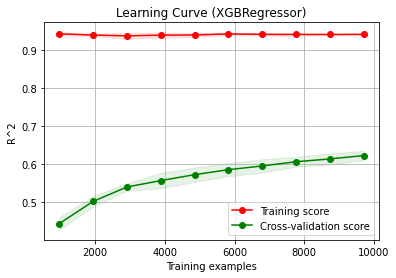

------------------------------------------------------------------------------------
R^2 score on validation set (seasonal_residual):  0.6434041147576495
MSE on validation set (seasonal_residual):  0.0018888788878723942


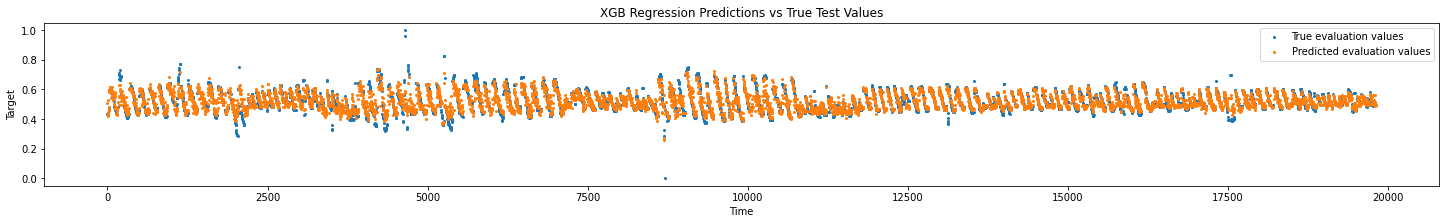

------------------------------------------------------------------------------------
KAN_L
R^2 score on test set (seasonal_residual):  0.5657236734390555
MSE on test set (seasonal_residual):  0.003006664845765559


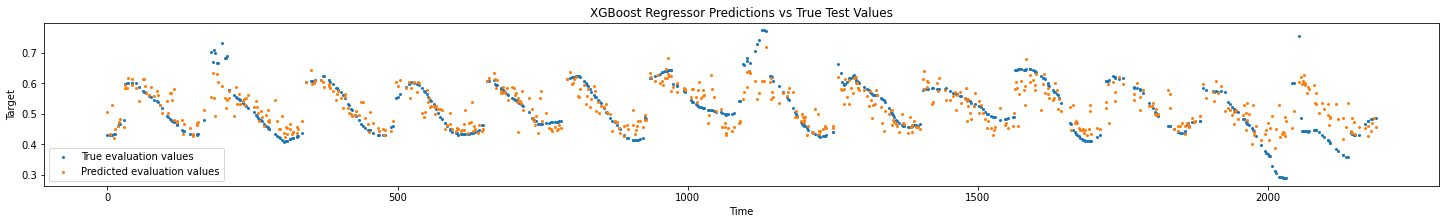

------------------------------------------------------------------------------------
KPC_L
R^2 score on test set (seasonal_residual):  0.5236685693318572
MSE on test set (seasonal_residual):  0.0010225608250853464


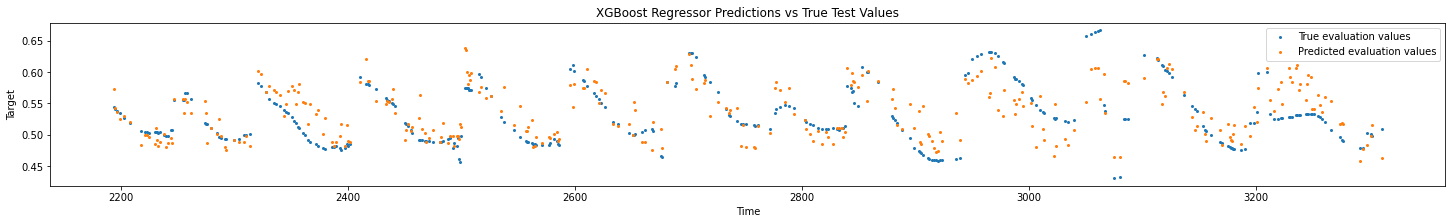

------------------------------------------------------------------------------------
MIT
R^2 score on test set (seasonal_residual):  0.507681861959654
MSE on test set (seasonal_residual):  0.0045327353059853945


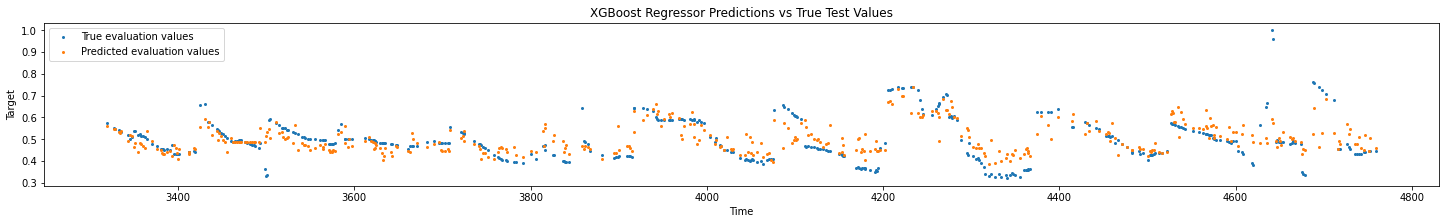

------------------------------------------------------------------------------------
NUK_L
R^2 score on test set (seasonal_residual):  0.6529029340720559
MSE on test set (seasonal_residual):  0.0030782308322213187


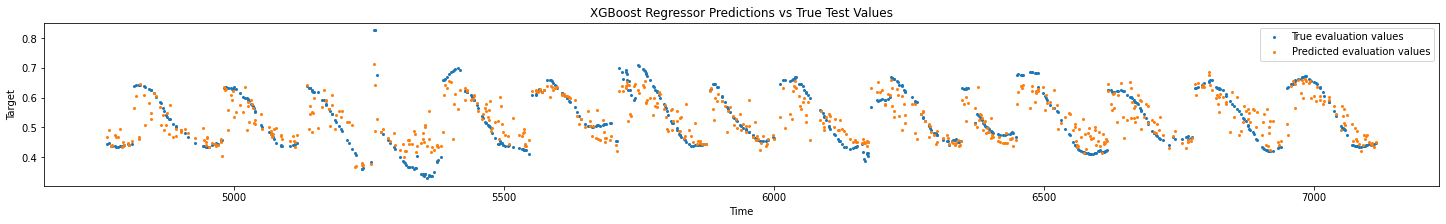

------------------------------------------------------------------------------------
NUK_U
R^2 score on test set (seasonal_residual):  0.6026780744092893
MSE on test set (seasonal_residual):  0.0006800078811182489


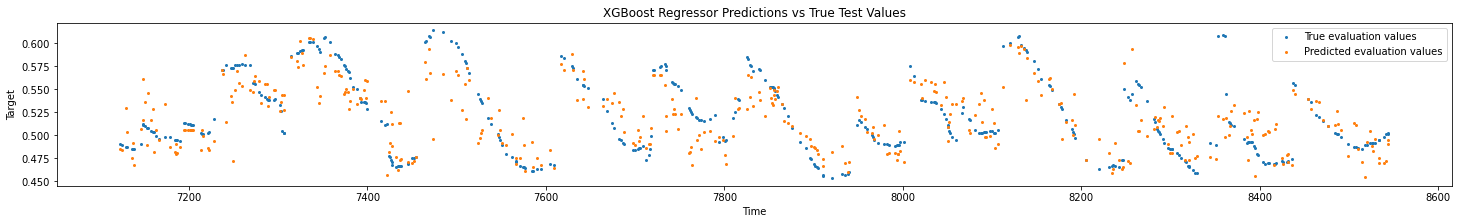

------------------------------------------------------------------------------------
QAS_L
R^2 score on test set (seasonal_residual):  0.6872943106222414
MSE on test set (seasonal_residual):  0.0032499418810343125


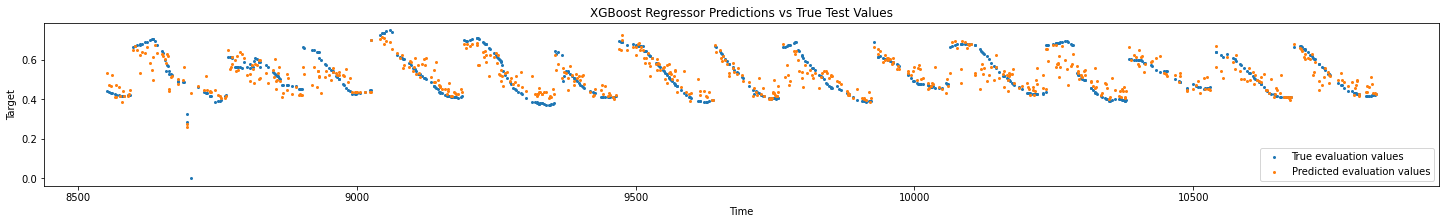

------------------------------------------------------------------------------------
QAS_U
R^2 score on test set (seasonal_residual):  0.49825847555278324
MSE on test set (seasonal_residual):  0.0006664972494153369


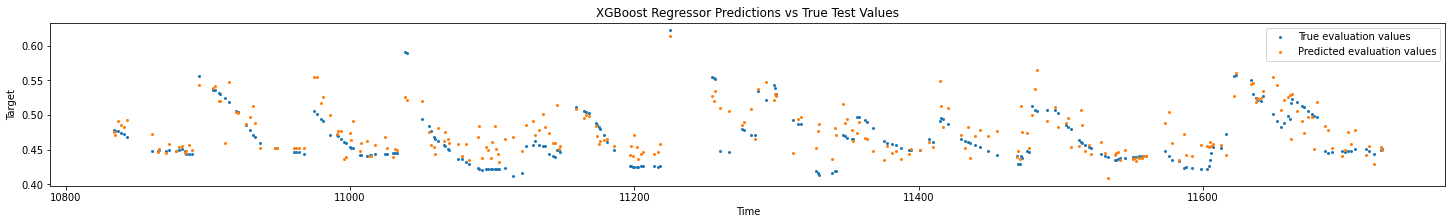

------------------------------------------------------------------------------------
SCO_L
R^2 score on test set (seasonal_residual):  0.7244893710957842
MSE on test set (seasonal_residual):  0.0009782622278824444


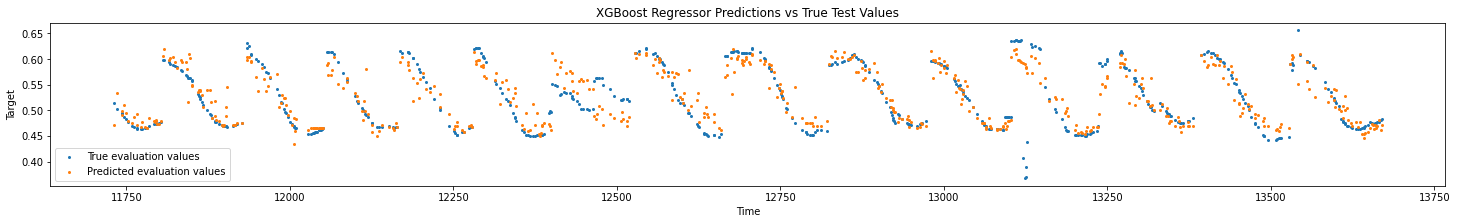

------------------------------------------------------------------------------------
SCO_U
R^2 score on test set (seasonal_residual):  0.7726349389103826
MSE on test set (seasonal_residual):  0.0004700847029232923


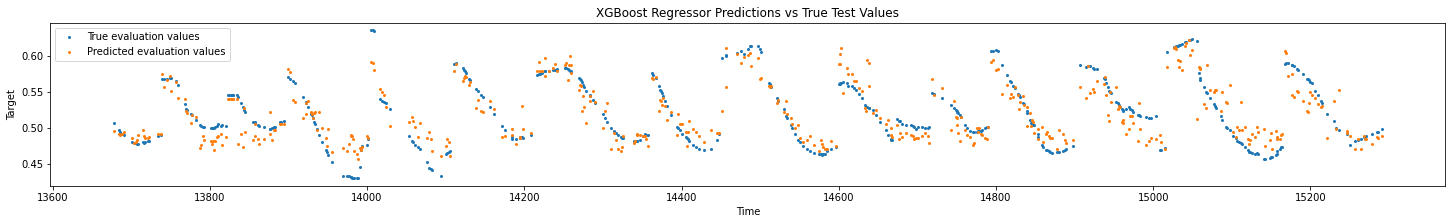

------------------------------------------------------------------------------------
TAS_L
R^2 score on test set (seasonal_residual):  0.6807247524384197
MSE on test set (seasonal_residual):  0.0014101365047246364


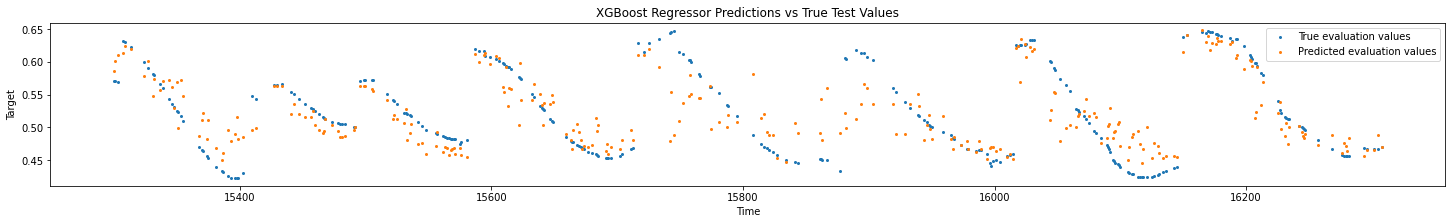

------------------------------------------------------------------------------------
THU_L
R^2 score on test set (seasonal_residual):  0.6067612247123203
MSE on test set (seasonal_residual):  0.0005755217585339977


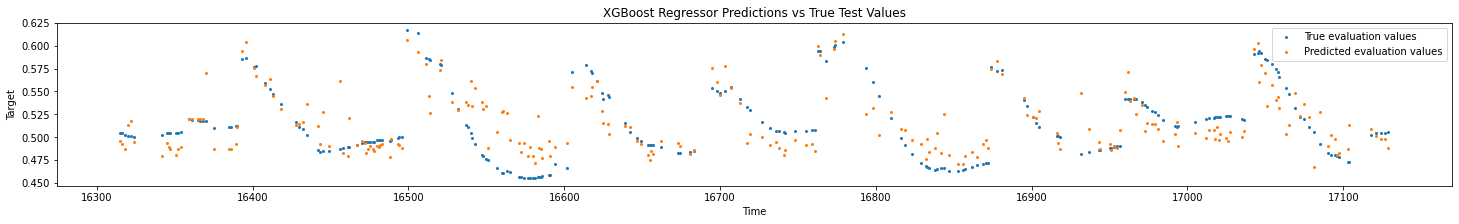

------------------------------------------------------------------------------------
UPE_L
R^2 score on test set (seasonal_residual):  0.6511146043349167
MSE on test set (seasonal_residual):  0.001101168092418986


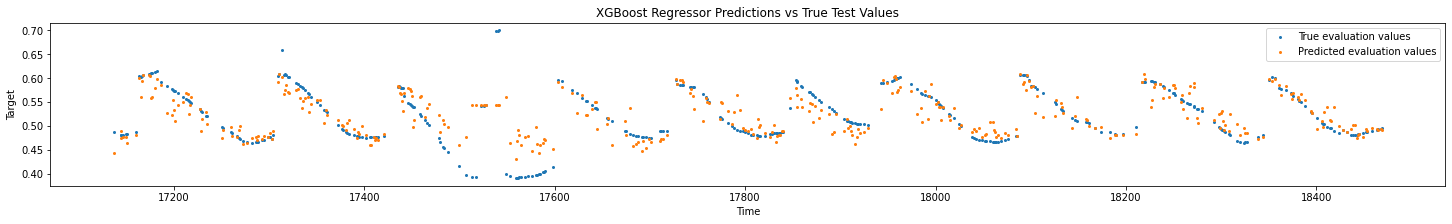

------------------------------------------------------------------------------------
UPE_U
R^2 score on test set (seasonal_residual):  0.49893368686423445
MSE on test set (seasonal_residual):  0.000633644715864639


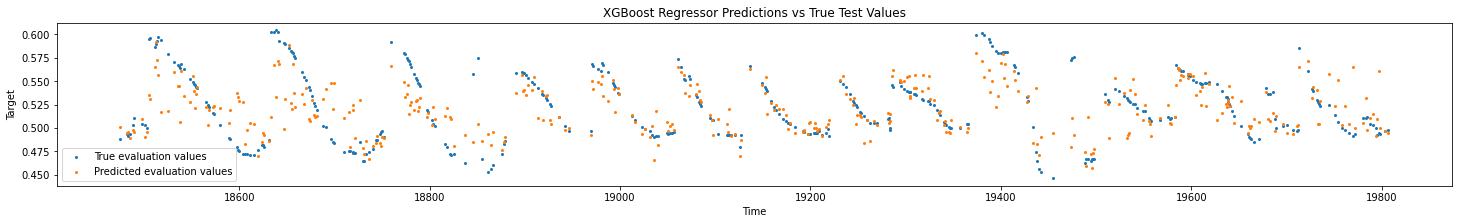

In [60]:
# XGB Regressor
model = xgb.XGBRegressor()

# Grid used in Hyperparameter Tuning
param_grid ={
    'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2],
    'max_depth': [5, 7, 9, 11, 13, 15],
    'min_child_weight': [1, 2, 4, 6, 8, 10], 
    'gamma': [0, 0.1, 0.5, 0.7, 1], 
    'subsample': [0.5, 0.7, 0.8, 0.9, 1], 
    'colsample_bytree': [0.5, 0.7, 0.8, 0.9, 1]
}

param_grid = {
'colsample_bytree': [1], 'gamma': [0], 'learning_rate': [0.05], 'max_depth': [15], 'min_child_weight': [10], 'subsample': [0.8]
}


# Define the grid search object
grid_search = GridSearchCV(model, param_grid = param_grid, cv=cv, n_jobs=-1, verbose=5)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding R^2 score on the test set
print(f"Best hyperparameters_{y}: ", grid_search.best_params_)
print('------------------------------------------------------------------------------------')
# Save the best model parameters as 'model' variable
exec(f"xgb_model_{y} = grid_search.best_estimator_")

# Evaluate the best model on the test set
y_pred = eval(f"xgb_model_{y}").predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred, squared=True)
print("Average R^2 test score from cv :", grid_search.cv_results_["mean_test_score"][0])
print("Standard deviation of R^2 test scores from cv:", grid_search.cv_results_["std_test_score"][0])
mean_test_score = grid_search.cv_results_["mean_test_score"][0]
std_test_score = grid_search.cv_results_["std_test_score"][0]

best_estimator = grid_search.best_estimator_
param_name = 'learning_rate'
param_range = np.arange(0.01, 0.05, 0.1)
#plot_validation_curve(best_estimator, "Validation Curve (XGBRegressor)", X_train, y_train, param_name, param_range, cv=cv)
#plt.show()

plot_learning_curve(best_estimator, "Learning Curve (XGBRegressor)", X_train, y_train, cv=cv)
plt.show()

print('------------------------------------------------------------------------------------')
print(f"R^2 score on validation set ({y}): ", r2)
print(f"MSE on validation set ({y}): ", mse)

y_pred_station = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_station = scaler.inverse_transform(y_test.values.reshape(-1, 1))

plt.figure(figsize=(25, 3))
plt.scatter(X_test.index, y_test_station, label="True evaluation values", alpha=1, s=4)
plt.scatter(X_test.index, y_pred_station, label="Predicted evaluation values", alpha=1, s=4)

plt.xlabel("Time")
plt.ylabel("Target")
plt.title("XGB Regression Predictions vs True Test Values")
plt.legend()
plt.show()


for value, station_name in enumerate(station_names):
    print('------------------------------------------------------------------------------------')
    print(station_name)

    # Subset X_train and X_test with the values of station_names
    X_train_station = X_train.loc[X_train['stid'] == value]
    X_test_station = X_test.loc[X_test['stid'] == value]

    # Subset y_train and y_test with the indices of X_train_station and X_test_station
    y_train_station = y_train.loc[X_train_station.index]
    y_test_station = y_test.loc[X_test_station.index]

    y_pred_station = eval(f"xgb_model_{y}").predict(X_test_station)
    y_pred_station = scaler.inverse_transform(y_pred_station.reshape(-1, 1))
    y_test_station = scaler.inverse_transform(y_test_station.values.reshape(-1, 1))
    
    y_pred_train_station = eval(f"xgb_model_{y}").predict(X_test_station)
    r2_station = r2_score(y_test_station, y_pred_station)
    mse_station = mean_squared_error(y_test_station, y_pred_station, squared=True)
    
    print(f"R^2 score on test set ({y}): ", r2_station)
    print(f"MSE on test set ({y}): ", mse_station)
    
    plt.figure(figsize=(25, 3))
    plt.scatter(X_test_station.index, y_test_station, label="True evaluation values", alpha=1, s=4)
    plt.scatter(X_test_station.index, y_pred_station, label="Predicted evaluation values", alpha=1, s=4)
   
    plt.xlabel("Time")
    plt.ylabel("Target")
    plt.title("XGBoost Regressor Predictions vs True Test Values")
    plt.legend()
    plt.show()


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters_seasonal_residual:  {'l2_regularization': 0, 'learning_rate': 0.05, 'max_depth': 15, 'max_iter': 500, 'min_samples_leaf': 10}
------------------------------------------------------------------------------------
Average R^2 test score from cv : 0.6183159971968681
Standard deviation of R^2 test scores from cv: 0.011876527674069472


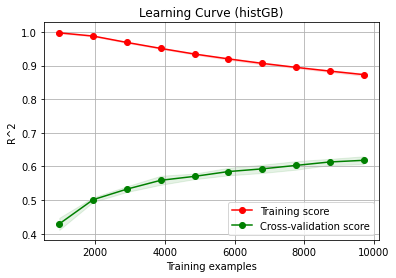

------------------------------------------------------------------------------------
R^2 score on validation set (seasonal_residual):  0.6230223062921546
MSE on validation set (seasonal_residual):  0.0019968407833972613


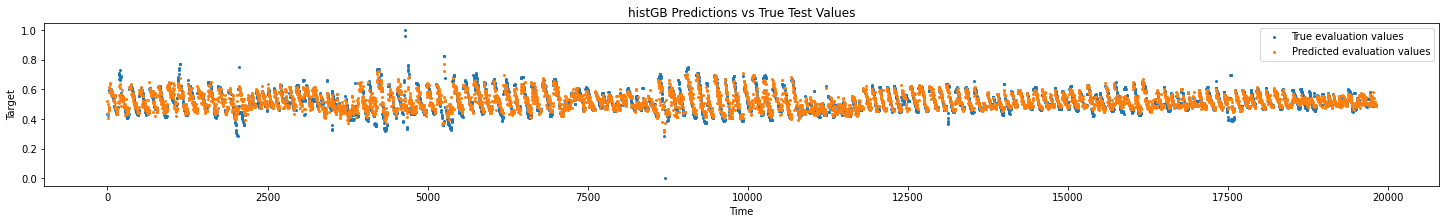

------------------------------------------------------------------------------------
KAN_L
R^2 score on test set (seasonal_residual):  0.5443897288957982
MSE on test set (seasonal_residual):  0.0031543680871273056


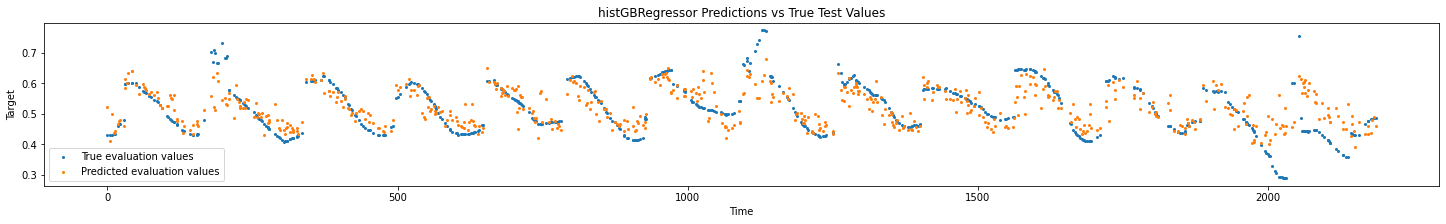

------------------------------------------------------------------------------------
KPC_L
R^2 score on test set (seasonal_residual):  0.5005110006134167
MSE on test set (seasonal_residual):  0.001072274157129137


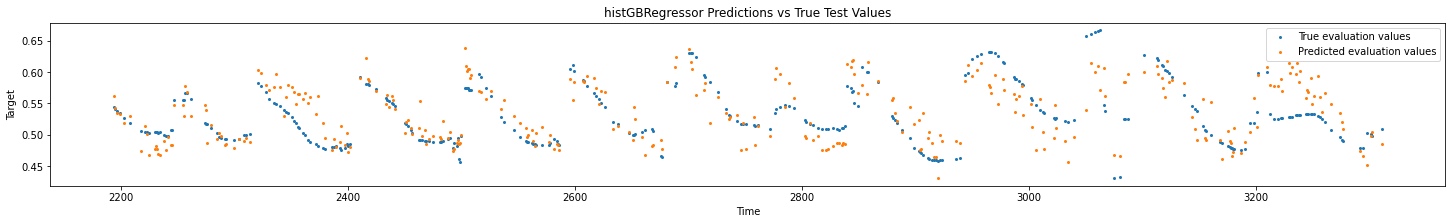

------------------------------------------------------------------------------------
MIT
R^2 score on test set (seasonal_residual):  0.47589870309463067
MSE on test set (seasonal_residual):  0.0048253604099408945


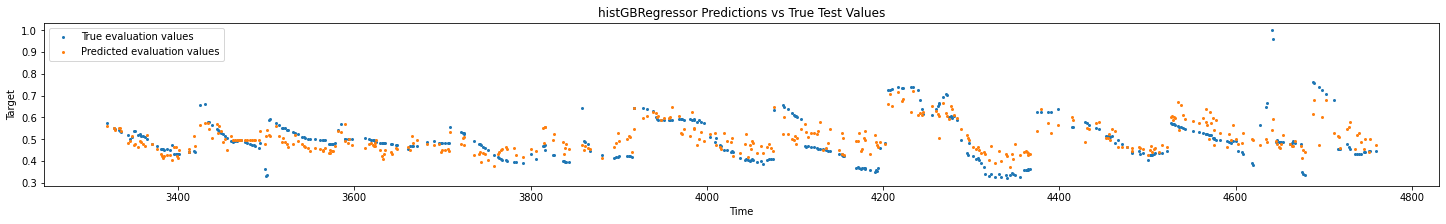

------------------------------------------------------------------------------------
NUK_L
R^2 score on test set (seasonal_residual):  0.6522662443254379
MSE on test set (seasonal_residual):  0.0030838773161619396


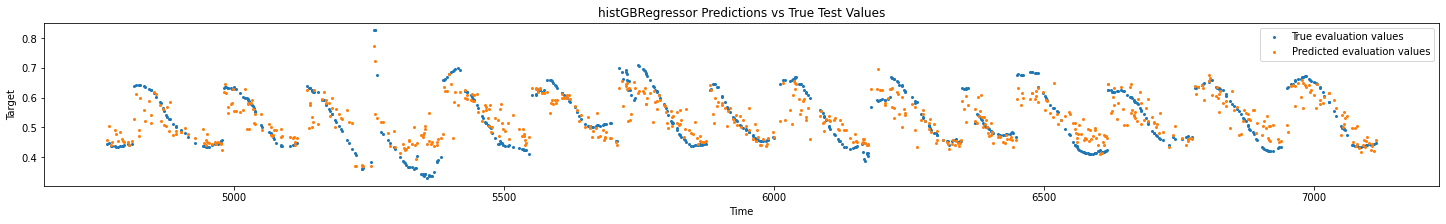

------------------------------------------------------------------------------------
NUK_U
R^2 score on test set (seasonal_residual):  0.5105647827069297
MSE on test set (seasonal_residual):  0.0008376577873503886


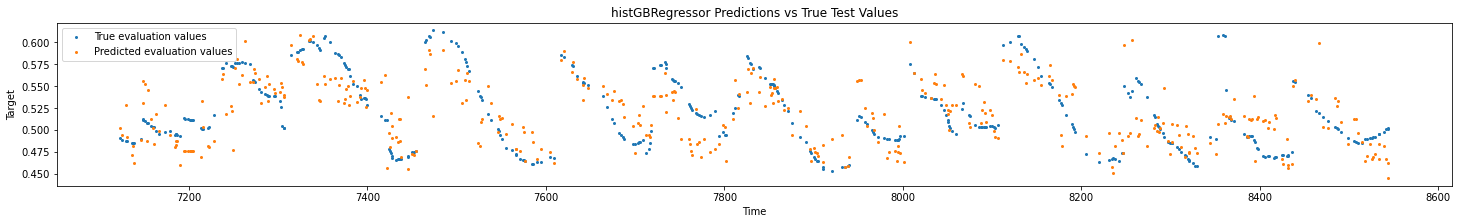

------------------------------------------------------------------------------------
QAS_L
R^2 score on test set (seasonal_residual):  0.6810066995128499
MSE on test set (seasonal_residual):  0.0033152888554265274


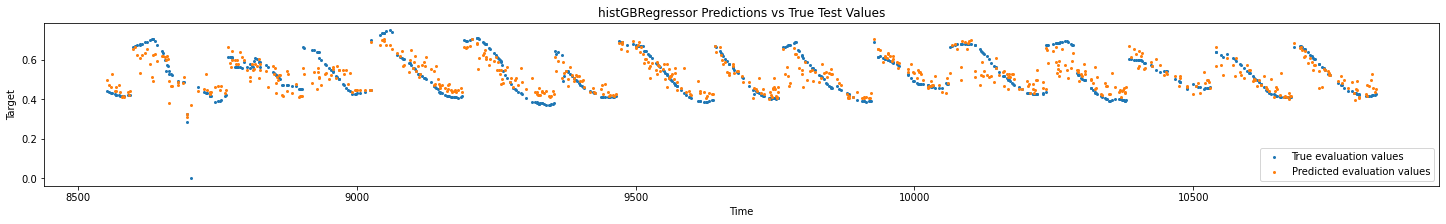

------------------------------------------------------------------------------------
QAS_U
R^2 score on test set (seasonal_residual):  0.39362166839204027
MSE on test set (seasonal_residual):  0.0008054934073216871


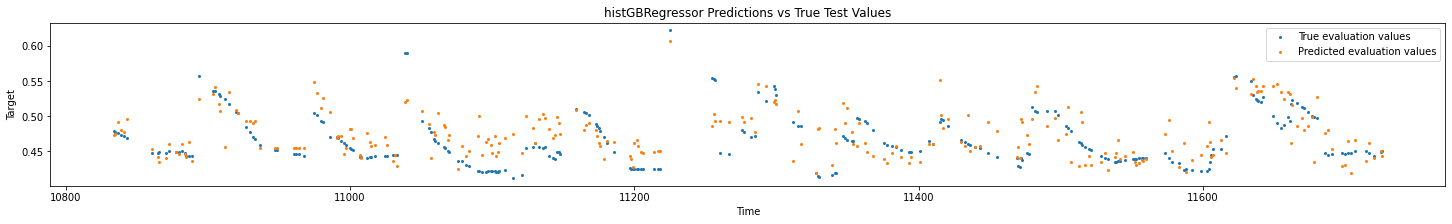

------------------------------------------------------------------------------------
SCO_L
R^2 score on test set (seasonal_residual):  0.6794242906826149
MSE on test set (seasonal_residual):  0.0011382758946510512


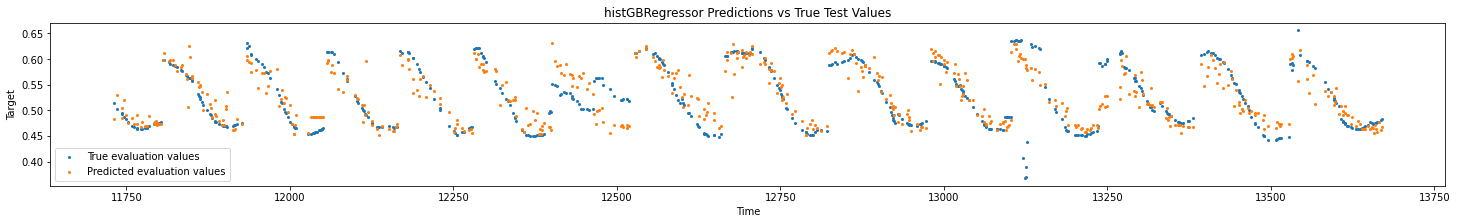

------------------------------------------------------------------------------------
SCO_U
R^2 score on test set (seasonal_residual):  0.7406901686972396
MSE on test set (seasonal_residual):  0.0005361315605347139


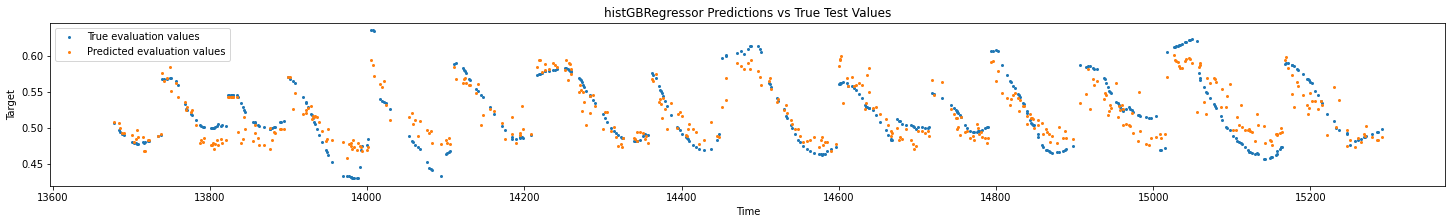

------------------------------------------------------------------------------------
TAS_L
R^2 score on test set (seasonal_residual):  0.661644968472488
MSE on test set (seasonal_residual):  0.0014944057992537427


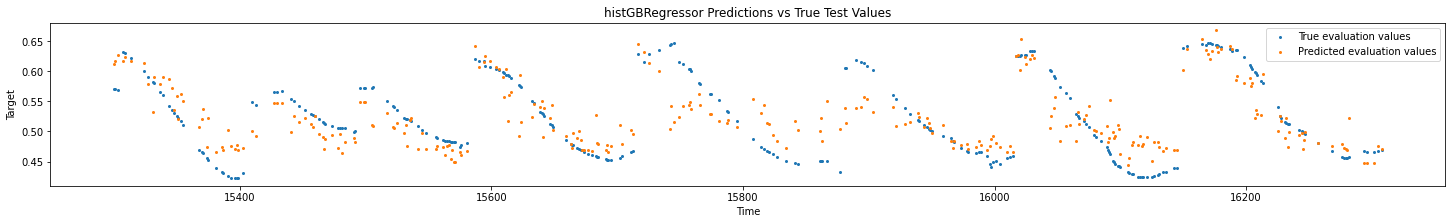

------------------------------------------------------------------------------------
THU_L
R^2 score on test set (seasonal_residual):  0.5804490085525256
MSE on test set (seasonal_residual):  0.0006140308117272732


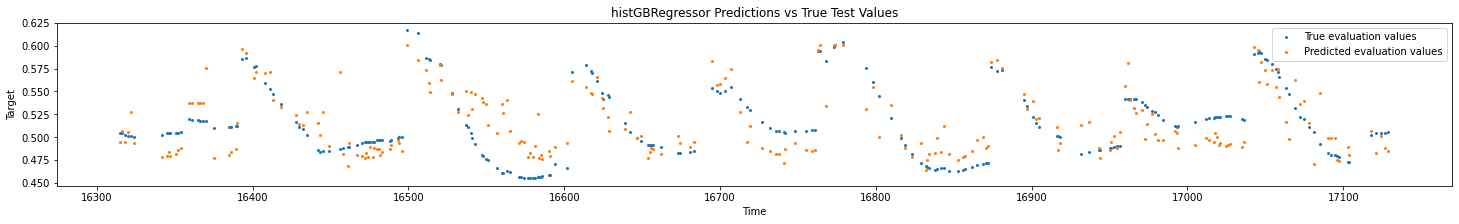

------------------------------------------------------------------------------------
UPE_L
R^2 score on test set (seasonal_residual):  0.6301012965339262
MSE on test set (seasonal_residual):  0.0011674912585765127


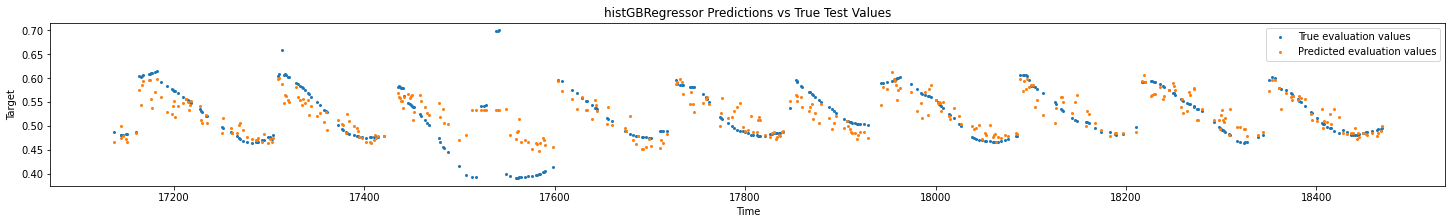

------------------------------------------------------------------------------------
UPE_U
R^2 score on test set (seasonal_residual):  0.38105567633719284
MSE on test set (seasonal_residual):  0.0007827123672492531


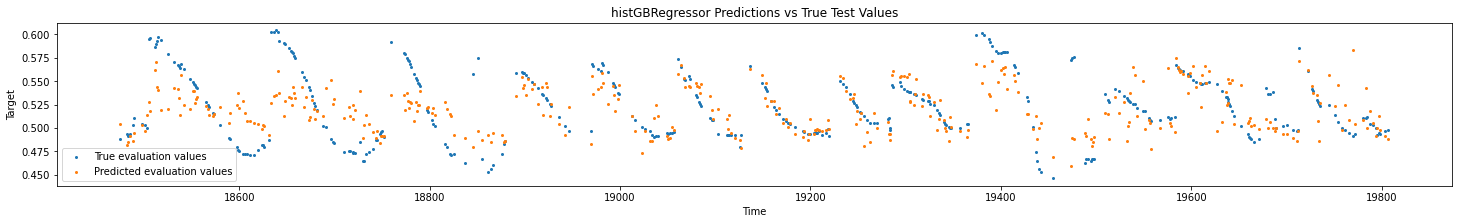

In [61]:
# This bit to find best HistGradientBoostingRegressor model for when Ablation == True and for both target variables
model = HistGradientBoostingRegressor()

# Grid used in Hyperparameter Tuning

param_grid = {
    'max_depth': [15],#[3, 5, 7],
    'min_samples_leaf': [10],#[1, 3, 5],
    'learning_rate': [0.05],#[0.1, 0.01, 0.001],
    'max_iter': [500],#[100, 500, 1000],
    'l2_regularization': [0],#[0, 0.1, 0.5]
}

# Define the grid search object
grid_search = GridSearchCV(model, param_grid = param_grid, cv=cv, n_jobs=-1, verbose=5)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)


# Print the best hyperparameters and the corresponding R^2 score on the test set
print(f"Best hyperparameters_{y}: ", grid_search.best_params_)
print('------------------------------------------------------------------------------------')
# Save the best model parameters as 'model' variable
exec(f"hist_model_{y} = grid_search.best_estimator_")

# Evaluate the best model on the test set
y_pred = eval(f"hist_model_{y}").predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred, squared=True)
print("Average R^2 test score from cv :", grid_search.cv_results_["mean_test_score"][0])
print("Standard deviation of R^2 test scores from cv:", grid_search.cv_results_["std_test_score"][0])
mean_test_score = grid_search.cv_results_["mean_test_score"][0]
std_test_score = grid_search.cv_results_["std_test_score"][0]

best_estimator = grid_search.best_estimator_
param_name = 'learning_rate'
param_range = np.arange(0.01, 0.05, 0.1)
#plot_validation_curve(best_estimator, "Validation Curve (XGBRegressor)", X_train, y_train, param_name, param_range, cv=cv)
#plt.show()

plot_learning_curve(best_estimator, "Learning Curve (histGB)", X_train, y_train, cv=cv)
plt.show()

print('------------------------------------------------------------------------------------')
print(f"R^2 score on validation set ({y}): ", r2)
print(f"MSE on validation set ({y}): ", mse)

y_pred_station = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_station = scaler.inverse_transform(y_test.values.reshape(-1, 1))

plt.figure(figsize=(25, 3))
plt.scatter(X_test.index, y_test_station, label="True evaluation values", alpha=1, s=4)
plt.scatter(X_test.index, y_pred_station, label="Predicted evaluation values", alpha=1, s=4)

plt.xlabel("Time")
plt.ylabel("Target")
plt.title("histGB Predictions vs True Test Values")
plt.legend()
plt.show()


for value, station_name in enumerate(station_names):
    print('------------------------------------------------------------------------------------')
    print(station_name)

    # Subset X_train and X_test with the values of station_names
    X_train_station = X_train.loc[X_train['stid'] == value]
    X_test_station = X_test.loc[X_test['stid'] == value]

    # Subset y_train and y_test with the indices of X_train_station and X_test_station
    y_train_station = y_train.loc[X_train_station.index]
    y_test_station = y_test.loc[X_test_station.index]

    y_pred_station = eval(f"hist_model_{y}").predict(X_test_station)
    y_pred_station = scaler.inverse_transform(y_pred_station.reshape(-1, 1))
    y_test_station = scaler.inverse_transform(y_test_station.values.reshape(-1, 1))
    
    y_pred_train_station = eval(f"hist_model_{y}").predict(X_test_station)
    r2_station = r2_score(y_test_station, y_pred_station)
    mse_station = mean_squared_error(y_test_station, y_pred_station, squared=True)
    
    print(f"R^2 score on test set ({y}): ", r2_station)
    print(f"MSE on test set ({y}): ", mse_station)
    
    plt.figure(figsize=(25, 3))
    plt.scatter(X_test_station.index, y_test_station, label="True evaluation values", alpha=1, s=4)
    plt.scatter(X_test_station.index, y_pred_station, label="Predicted evaluation values", alpha=1, s=4)
   
    plt.xlabel("Time")
    plt.ylabel("Target")
    plt.title("histGBRegressor Predictions vs True Test Values")
    plt.legend()
    plt.show()

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Average R^2 test score from cv : 0.5353807387700249
Standard deviation of R^2 test scores from cv: 0.010587244144180843


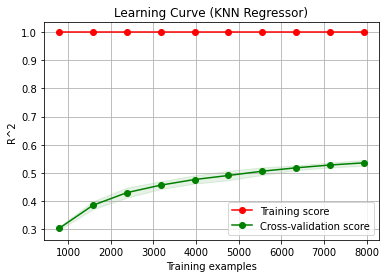

------------------------------------------------------------------------------------
R^2 score on validation set (seasonal_residual):  0.5805898124605158
MSE on validation set (seasonal_residual):  0.0020805042538353333


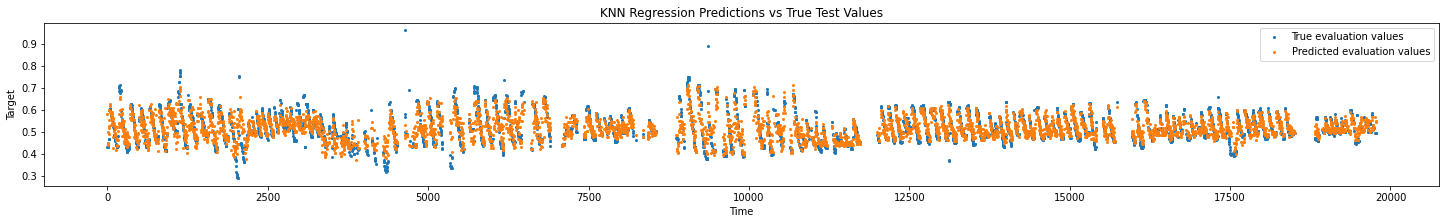

------------------------------------------------------------------------------------
KAN_L
R^2 score on test set (seasonal_residual):  0.48217960906256396
MSE on test set (seasonal_residual):  0.0035789268821779944


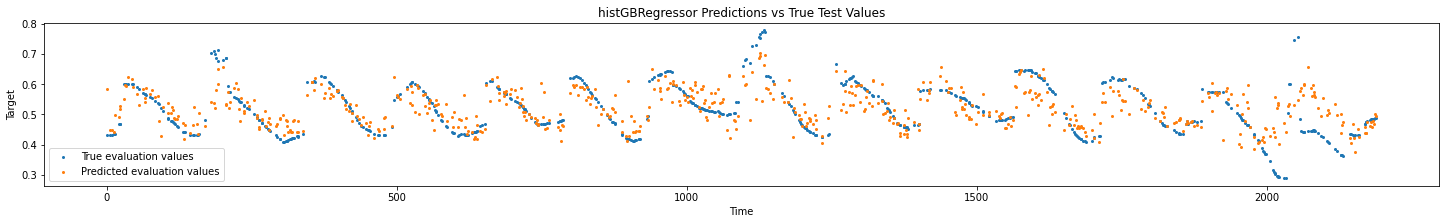

------------------------------------------------------------------------------------
KPC_L
R^2 score on test set (seasonal_residual):  0.34906490589471273
MSE on test set (seasonal_residual):  0.001562554651778047


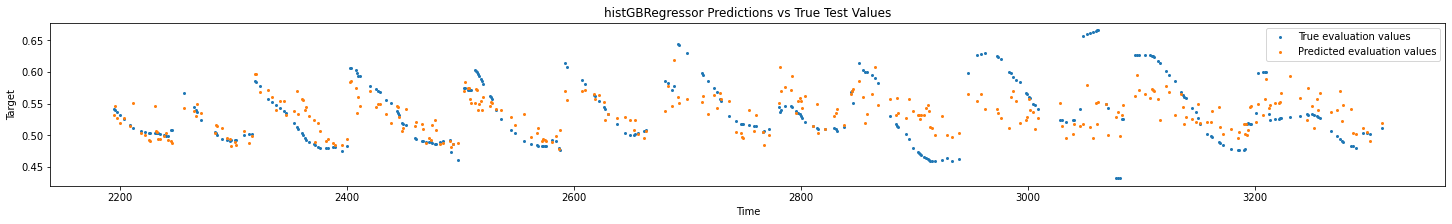

------------------------------------------------------------------------------------
MIT
R^2 score on test set (seasonal_residual):  0.29916915938012123
MSE on test set (seasonal_residual):  0.003819165508941854


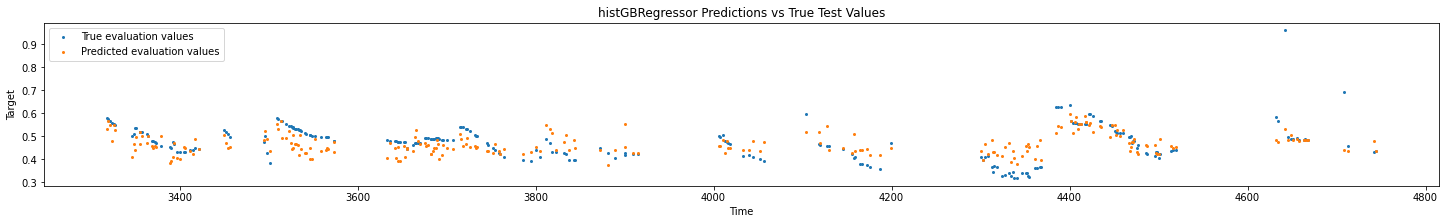

------------------------------------------------------------------------------------
NUK_L
R^2 score on test set (seasonal_residual):  0.5302348388272544
MSE on test set (seasonal_residual):  0.0034563047622622927


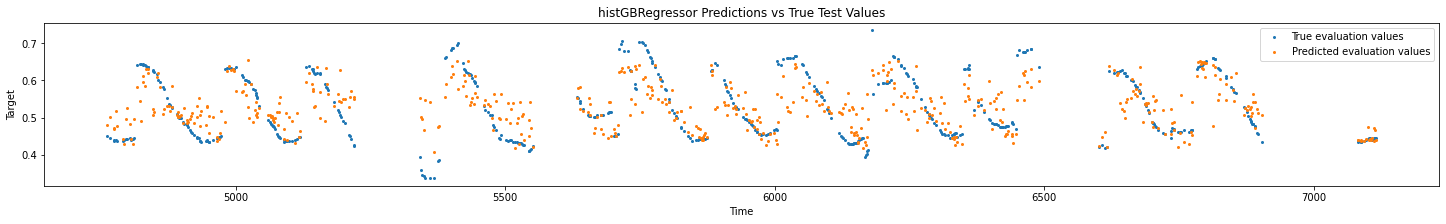

------------------------------------------------------------------------------------
NUK_U
R^2 score on test set (seasonal_residual):  0.5667457899714443
MSE on test set (seasonal_residual):  0.0007086647408692521


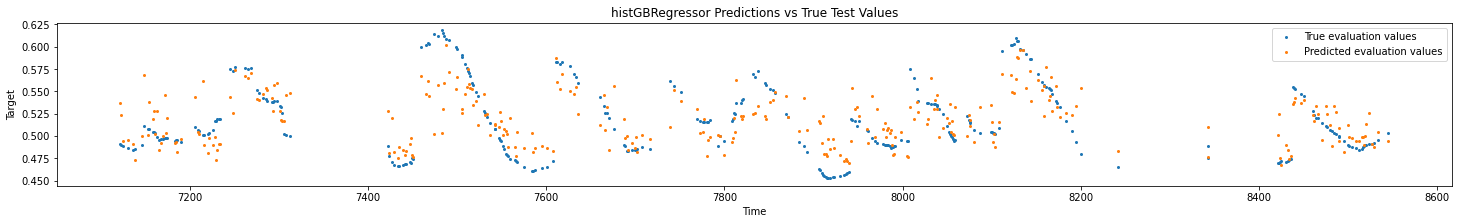

------------------------------------------------------------------------------------
QAS_L
R^2 score on test set (seasonal_residual):  0.6508298010403122
MSE on test set (seasonal_residual):  0.004242163325499723


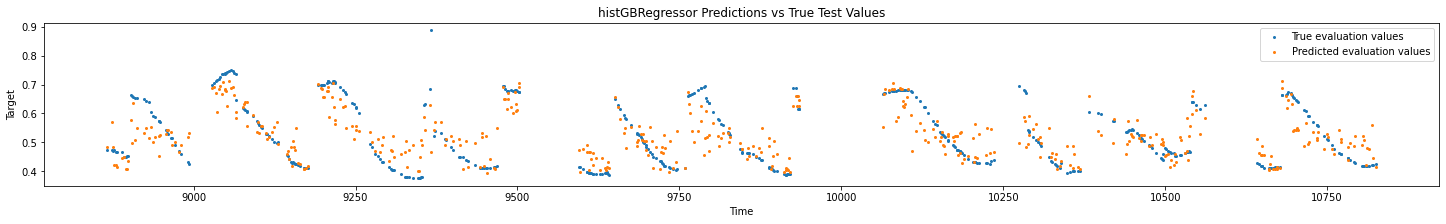

------------------------------------------------------------------------------------
QAS_U
R^2 score on test set (seasonal_residual):  0.6041593147416133
MSE on test set (seasonal_residual):  0.0006218526412359268


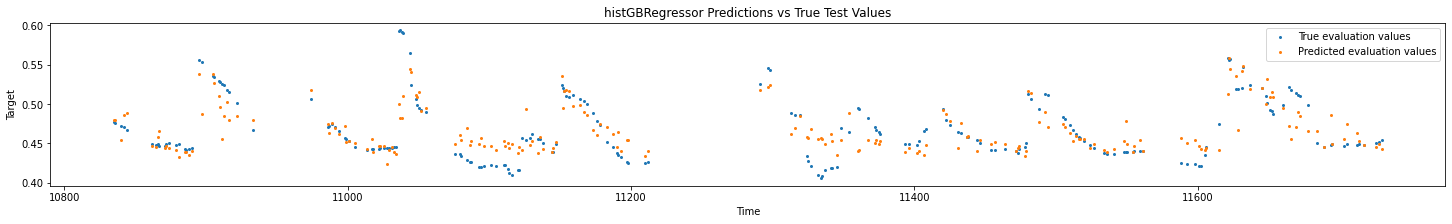

------------------------------------------------------------------------------------
SCO_L
R^2 score on test set (seasonal_residual):  0.6095130775204805
MSE on test set (seasonal_residual):  0.0014548217474523197


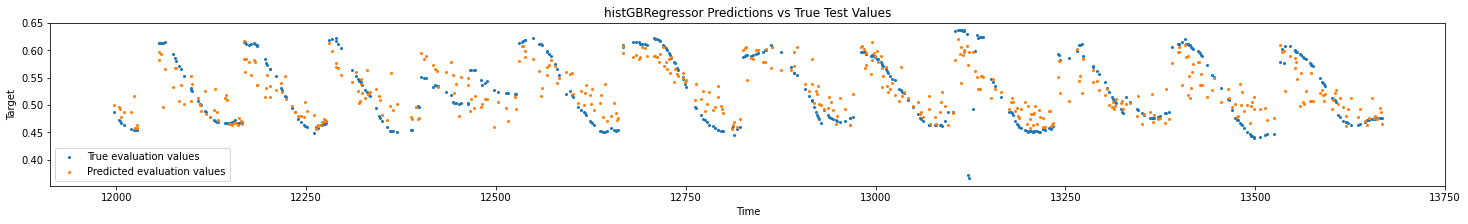

------------------------------------------------------------------------------------
SCO_U
R^2 score on test set (seasonal_residual):  0.7174351943797297
MSE on test set (seasonal_residual):  0.0005763059290952502


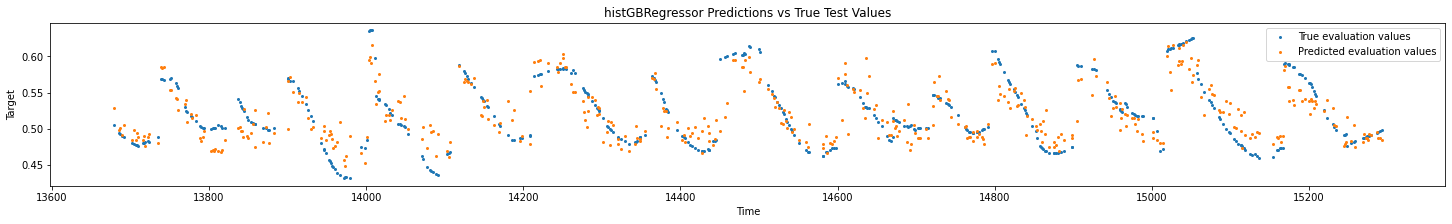

------------------------------------------------------------------------------------
TAS_L
R^2 score on test set (seasonal_residual):  0.6843442485120725
MSE on test set (seasonal_residual):  0.0013984885445982298


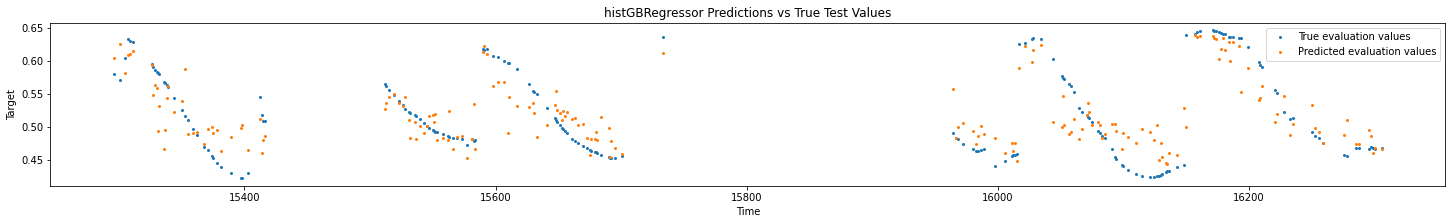

------------------------------------------------------------------------------------
THU_L
R^2 score on test set (seasonal_residual):  0.6281190832633343
MSE on test set (seasonal_residual):  0.0005928858705598552


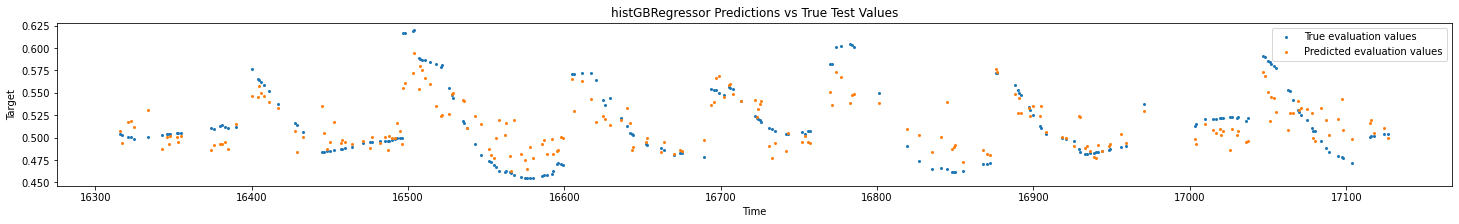

------------------------------------------------------------------------------------
UPE_L
R^2 score on test set (seasonal_residual):  0.5886698869041156
MSE on test set (seasonal_residual):  0.0011275385256568084


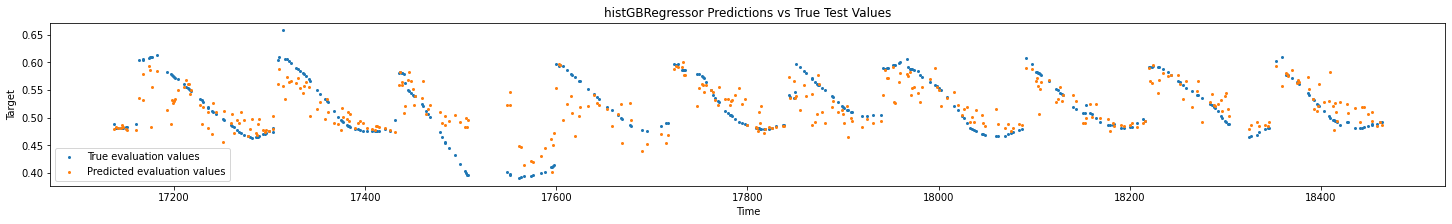

------------------------------------------------------------------------------------
UPE_U
R^2 score on test set (seasonal_residual):  0.5380599363973054
MSE on test set (seasonal_residual):  0.0005390784149108201


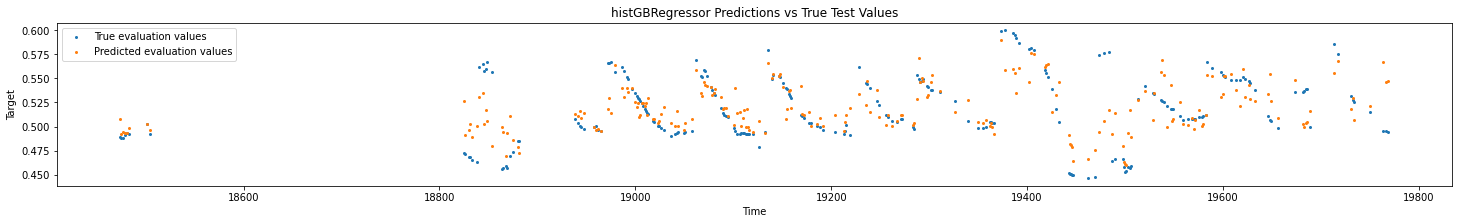

In [62]:
from sklearn.neighbors import KNeighborsRegressor


# Create the k-Nearest Neighbors Regressor
knn_model = KNeighborsRegressor()

# Grid used in Hyperparameter Tuning
param_grid = {
    'n_neighbors': [7], #range(1, 11),
    'weights':['distance'], # ['uniform', 'distance'],
    'metric': ['manhattan']#['euclidean', 'manhattan', 'minkowski']
}

# Create grid search object
grid_search = GridSearchCV(knn_model, param_grid, cv=cv, n_jobs=-1, verbose = 2) #, scoring='neg_mean_squared_error'

# Fit the grid search object to the training data
grid_search.fit(X_train_base, y_train_base)

# Get the best estimator
best_knn_model = grid_search.best_estimator_
best_estimator = grid_search.best_estimator_


# Evaluate the best model on the test set
y_pred_base = best_knn_model.predict(X_test_base)
r2 = r2_score(y_test_base, y_pred_base)
mse = mean_squared_error(y_test_base, y_pred_base, squared=True)

print("Best hyperparameters:", grid_search.best_params_)

print("Average R^2 test score from cv :", grid_search.cv_results_["mean_test_score"][0])
print("Standard deviation of R^2 test scores from cv:", grid_search.cv_results_["std_test_score"][0])

plot_learning_curve(best_estimator, "Learning Curve (KNN Regressor)", X_train_base, y_train_base, cv=cv)
plt.show()

#print("Average R^2 test score from cv :", grid_search.cv_results_["mean_test_score"][0])
#print("Standard deviation of R^2 test scores from cv:", grid_search.cv_results_["std_test_score"][0])
#mean_test_score = grid_search.cv_results_["mean_test_score"][0]
#std_test_score = grid_search.cv_results_["std_test_score"][0]

#best_estimator = grid_search.best_estimator_
#param_name = 'learning_rate'
#param_range = np.arange(0.01, 0.05, 0.1)
#plot_validation_curve(best_estimator, "Validation Curve (XGBRegressor)", X_train, y_train, param_name, param_range, cv=cv)
#plt.show()

#plot_learning_curve(best_estimator, "Learning Curve (XGBRegressor)", X_train, y_train, cv=cv)
#plt.show()

print('------------------------------------------------------------------------------------')
print(f"R^2 score on validation set ({y}): ", r2)
print(f"MSE on validation set ({y}): ", mse)

y_pred_station = scaler.inverse_transform(y_pred_base.reshape(-1, 1))
y_test_station = scaler.inverse_transform(y_test_base.values.reshape(-1, 1))

plt.figure(figsize=(25, 3))
plt.scatter(X_test_base.index, y_test_station, label="True evaluation values", alpha=1, s=4)
plt.scatter(X_test_base.index, y_pred_station, label="Predicted evaluation values", alpha=1, s=4)

plt.xlabel("Time")
plt.ylabel("Target")
plt.title("KNN Regression Predictions vs True Test Values")
plt.legend()
plt.show()


for value, station_name in enumerate(station_names):
    print('------------------------------------------------------------------------------------')
    print(station_name)

    # Subset X_train and X_test with the values of station_names
    X_train_station = X_train_base.loc[X_train_base['stid'] == value]
    X_test_station = X_test_base.loc[X_test_base['stid'] == value]

    # Subset y_train and y_test with the indices of X_train_station and X_test_station
    y_train_station = y_train_base.loc[X_train_station.index]
    y_test_station = y_test_base.loc[X_test_station.index]

    y_pred_station = best_knn_model.predict(X_test_station)
    y_pred_station = scaler.inverse_transform(y_pred_station.reshape(-1, 1))
    y_test_station = scaler.inverse_transform(y_test_station.values.reshape(-1, 1))
    
    y_pred_train_station = best_knn_model.predict(X_test_station)
    r2_station = r2_score(y_test_station, y_pred_station)
    mse_station = mean_squared_error(y_test_station, y_pred_station, squared=True)
    
    print(f"R^2 score on test set ({y}): ", r2_station)
    print(f"MSE on test set ({y}): ", mse_station)
    
    plt.figure(figsize=(25, 3))
    plt.scatter(X_test_station.index, y_test_station, label="True evaluation values", alpha=1, s=4)
    plt.scatter(X_test_station.index, y_pred_station, label="Predicted evaluation values", alpha=1, s=4)
   
    plt.xlabel("Time")
    plt.ylabel("Target")
    plt.title("histGBRegressor Predictions vs True Test Values")
    plt.legend()
    plt.show()


------

R^2 score on validation set (filtred):  0.716789572383262
MSE on validation set (filtred):  0.0017542387357122797
Count of filtred values:  2166
------------------------------------------------------------------------------


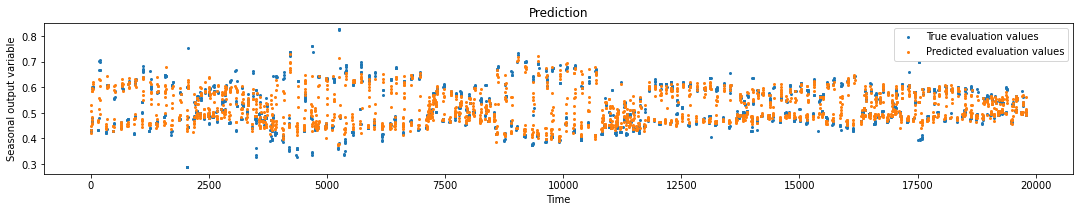

KAN_L
R^2 score on validation set (filtred):  0.543124606065827
RMSE on validation set (filtred):  0.0041500004953126035
Count of filtred values:  171


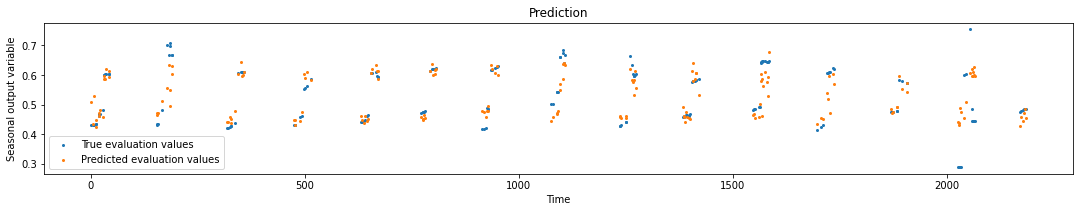

KPC_L
R^2 score on validation set (filtred):  0.6665806856097438
RMSE on validation set (filtred):  0.0007617450866048446
Count of filtred values:  151


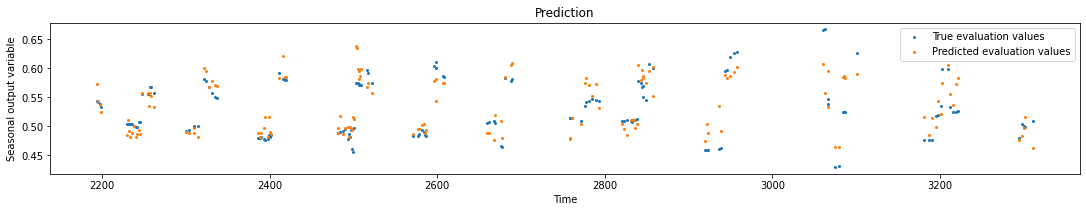

MIT
R^2 score on validation set (filtred):  0.5499704602394067
RMSE on validation set (filtred):  0.004369209518344535
Count of filtred values:  167


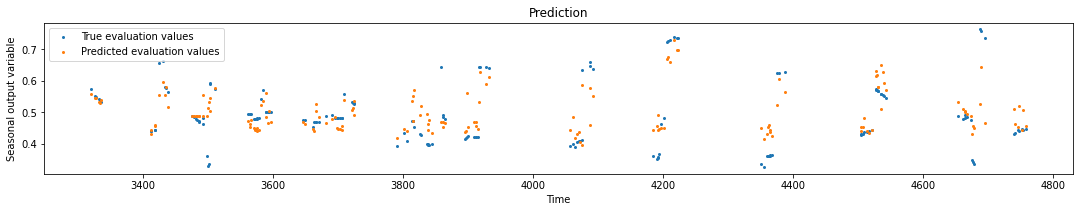

NUK_L
R^2 score on validation set (filtred):  0.6964183531170279
RMSE on validation set (filtred):  0.0037112133963946928
Count of filtred values:  203


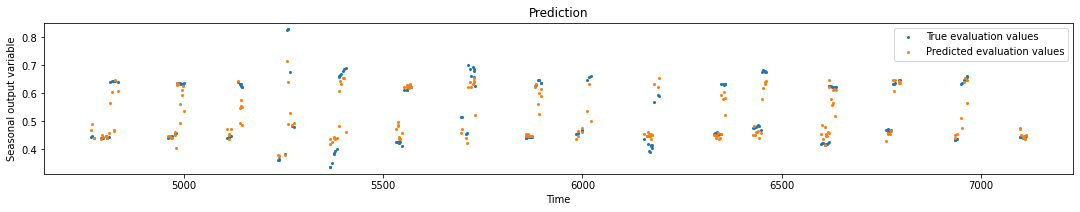

NUK_U
R^2 score on validation set (filtred):  0.5837446764380202
RMSE on validation set (filtred):  0.0007731163171023712
Count of filtred values:  193


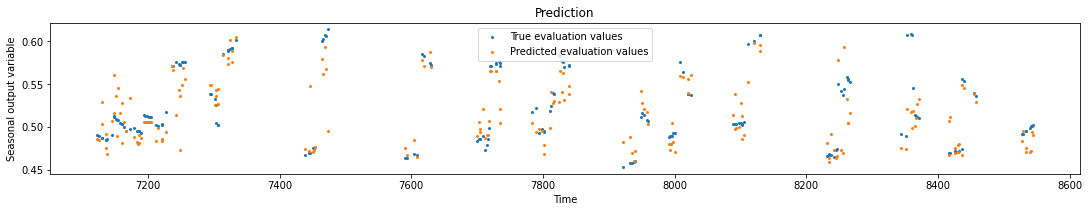

QAS_L
R^2 score on validation set (filtred):  0.8124045309698376
RMSE on validation set (filtred):  0.002704005474715164
Count of filtred values:  198


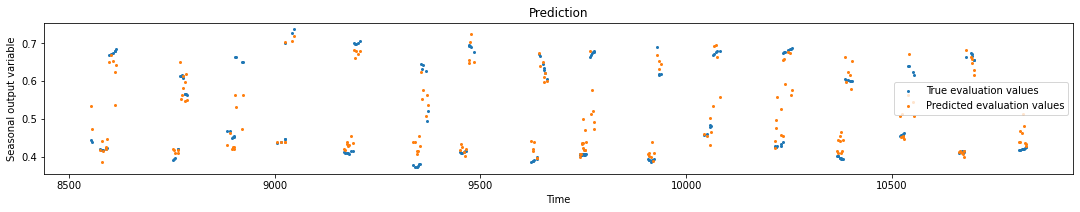

QAS_U
R^2 score on validation set (filtred):  0.5641018724633864
RMSE on validation set (filtred):  0.0007075259197357071
Count of filtred values:  148


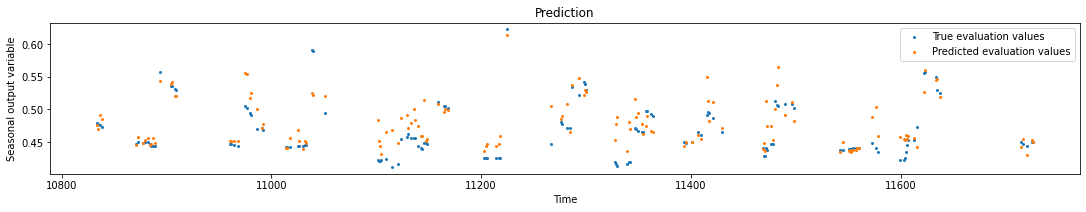

SCO_L
R^2 score on validation set (filtred):  0.8305448092736589
RMSE on validation set (filtred):  0.0008264790849668039
Count of filtred values:  197


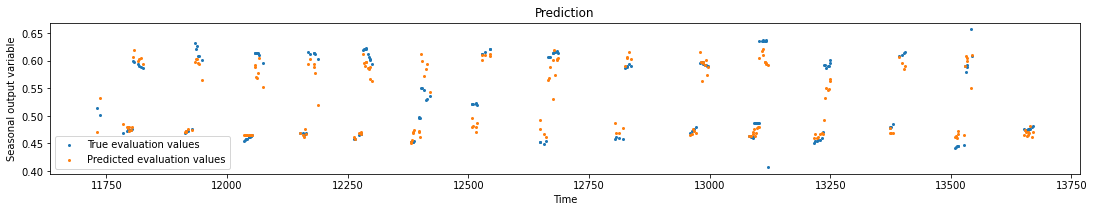

SCO_U
R^2 score on validation set (filtred):  0.8270795256782334
RMSE on validation set (filtred):  0.0004525724650332975
Count of filtred values:  193


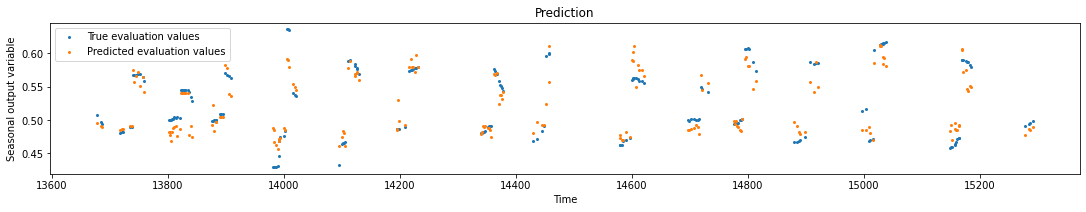

TAS_L
R^2 score on validation set (filtred):  0.8056902532296367
RMSE on validation set (filtred):  0.0011015102341397195
Count of filtred values:  92


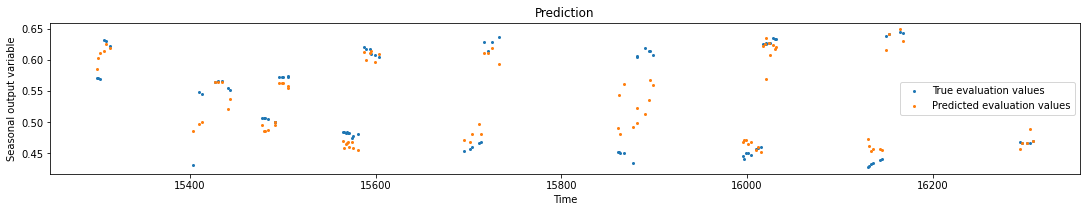

THU_L
R^2 score on validation set (filtred):  0.7818156936613254
RMSE on validation set (filtred):  0.00037341917117311263
Count of filtred values:  132


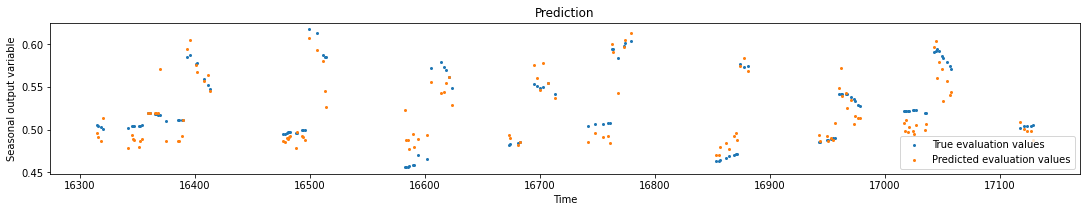

UPE_L
R^2 score on validation set (filtred):  0.6963881540288656
RMSE on validation set (filtred):  0.0014220653870484353
Count of filtred values:  152


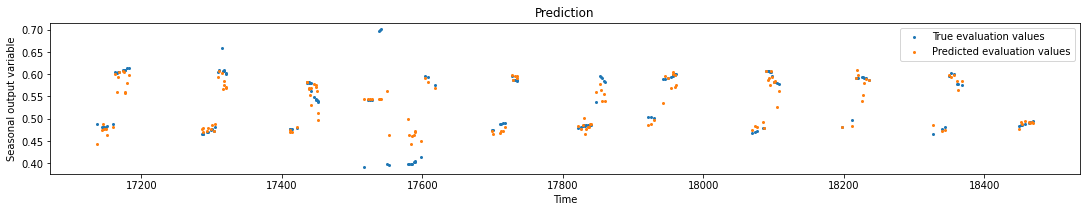

UPE_U
R^2 score on validation set (filtred):  0.6890601989745824
RMSE on validation set (filtred):  0.0005071464732139174
Count of filtred values:  169


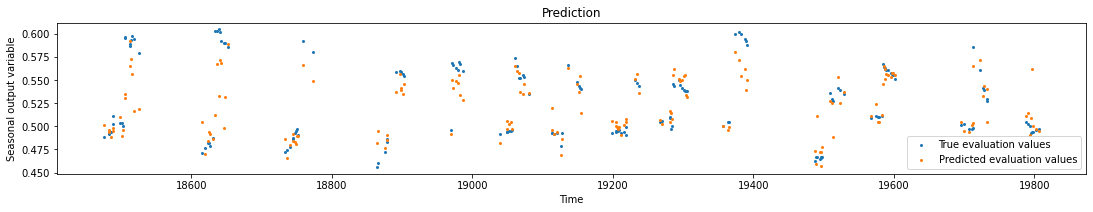

In [63]:
#filter = pd.concat([pd.Series(indices_first_melt_day), pd.Series(indices_last_melt_day)])
filter = expanded_indices_first + expanded_indices_last

# Evaluate the best model on the test set
y_pred =  xgb_model_seasonal_residual.predict(X_test.iloc[X_test.index.isin(filter)]) #eval(f"xgb_model_{y}").predict(X_test.iloc[filter])
y_test_filter = y_test.iloc[y_test.index.isin(filter)]

r2 = r2_score(y_test_filter, y_pred)
mse = mean_squared_error(y_test_filter, y_pred, squared=True)

print(f"R^2 score on validation set (filtred): ", r2)
print(f"MSE on validation set (filtred): ", mse)
print(f"Count of filtred values: ", len(y_test_filter))
print("------------------------------------------------------------------------------")

plt.figure(figsize=(15,10))
plt.subplot(4,1,4)
plt.title("Prediction")
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
plt.scatter(y_test_filter.index, y_test_filter.iloc[y_test_filter.index.isin(filter)], label="True evaluation values", alpha=1, s=4)
plt.scatter(y_test_filter.index, y_pred, label="Predicted evaluation values", alpha=1, s=4)
plt.xlabel('Time')
plt.ylabel('Seasonal output variable')
plt.legend()
plt.show()
    
for value, station_name in enumerate(station_names):
    print(station_name)

    plt.figure(figsize=(15,10))
    plt.subplot(4,1,4)
    plt.title("Prediction")
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)

    # Subset X_train and X_test with the values of station_names
    X_train_station = X_train.loc[X_train['stid'] == value]
    X_test_station = X_test.loc[X_test['stid'] == value]

    # Subset y_train and y_test with the indices of X_train_station and X_test_station
    y_train_station = y_train.loc[X_train_station.index]
    y_test_station = y_test.loc[X_test_station.index]

    y_pred_station = xgb_model_seasonal_residual.predict(X_test_station.iloc[X_test_station.index.isin(filter)])#eval(f"xgb_model_{y}").predict(X_test_station.iloc[filter])
    #y_pred_station = scaler.inverse_transform(y_pred_station.reshape(-1, 1))
    
    y_test_filter_station = y_test_station.iloc[y_test_station.index.isin(filter)]
    #y_test_filter_station = scaler.inverse_transform(y_test_filter_station.values.reshape(-1, 1))#.values.reshape(-1, 1))
    
    r2_station = r2_score(y_test_filter_station, y_pred_station)
    mse_station = mean_squared_error(y_test_filter_station, y_pred_station, squared=True)
    
    print(f"R^2 score on validation set (filtred): ", r2_station)
    print(f"RMSE on validation set (filtred): ", mse_station)
    print(f"Count of filtred values: ", len(y_test_filter_station))

    # Plot the seasonal output variable, trained values, tested values, and predicted values
  #  plt.scatter(y_train_station.index, y_train_station, label='Trained values', color='blue', linewidth=1)
    plt.scatter(y_test_filter_station.index, y_test_station.iloc[y_test_station.index.isin(filter)], label="True evaluation values", alpha=1, s=4)
    plt.scatter(y_test_filter_station.index, y_pred_station, label="Predicted evaluation values", alpha=1, s=4)
    
 #   plt.scatter(y_test_filter_station.index, y_test_station.iloc[y_test_station.index.isin(filter)], label='True values',  linewidth=0.5)
 #   plt.scatter(y_test_filter_station.index, y_pred_station, label= 'Predicted values',linewidth=0.4)


    # Plot the pre_max values
    #plt.scatter(indices_pre_max, df.loc[indices_pre_max, 'seasonal_residual'], c='r', marker='.', label='pre_max', s=4 )

    # Plot the post_max values
    #plt.scatter(indices_post_max, df.loc[indices_post_max, 'seasonal_residual'], c='g', marker='.', label='post_max',s=4)

    # Plot the pre_min values
    #plt.scatter(indices_pre_min, df.loc[indices_pre_min, 'seasonal_residual'], c='r', marker='.', label='pre_min',s=4)

    # Plot the post_min values
    #plt.scatter(indices_post_min, df.loc[indices_post_min, 'seasonal_residual'], c='g', marker='.', label='post_min',s=4)

    plt.xlabel('Time')
    plt.ylabel('Seasonal output variable')
    plt.legend()
    plt.show()

## Filter by Melting Season and get feature importances 

In [64]:
import shap

explainer = eval(f"shap.Explainer(xgb_model_{y})")

In [65]:
X_set = X_test
y_set = y_test 

positive_color = "#ca0020"
negative_color = "#92c5de"

In [66]:
# Filter out here whatever period to focus on

#filter = indices_middle.to_list()
#filter = indices_last_melt_day.to_list()
filter = expanded_indices_last
#filter = indices_first_melt_day.to_list()
#filter = expanded_indices_first

#shap_values = explainer(X_set.loc[filter])
shap_values = explainer(X_set.iloc[X_set.index.isin(filter)])

mean_abs_shap_values = shap_values.abs.mean(0)

#X = X_set.loc[filter]
X = X_set.iloc[X_set.index.isin(filter)]
y_set = y_set[y_set.index.isin(filter)]
max_abs_shap_value = np.max(np.abs(shap_values.values))
shap_values = shap_values.values / max_abs_shap_value

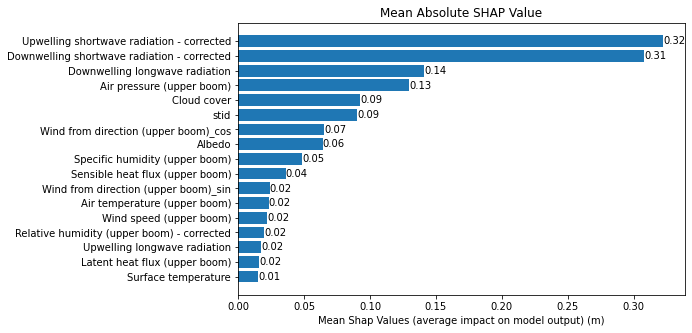

In [67]:
feature_names = X_set.columns
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)

# Get the sorted order of the features based on the mean absolute SHAP values
sorted_feature_indices = np.argsort(mean_abs_shap_values)
sorted_feature_names = feature_names[sorted_feature_indices]
# Create a custom vertical summary plot with feature labels on the left
plt.figure(figsize=(8, 5))
bar_plot = plt.barh(sorted_feature_names, mean_abs_shap_values[sorted_feature_indices])
plt.xlabel("Mean Shap Values (average impact on model output) (m)")
plt.title("Mean Absolute SHAP Value")
# Add labels to the bars
for rect in bar_plot:
    width = rect.get_width()
    plt.text(width, rect.get_y() + rect.get_height() / 2.0, "{:.2f}".format(width), ha="left", va="center")
plt.show()

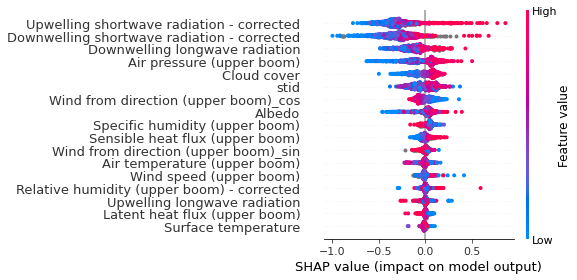

In [68]:
shap.summary_plot(shap_values, X, plot_type="dot", plot_size = (8,4))

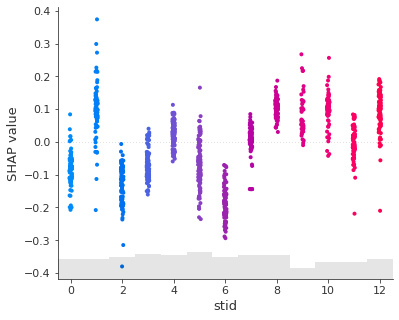

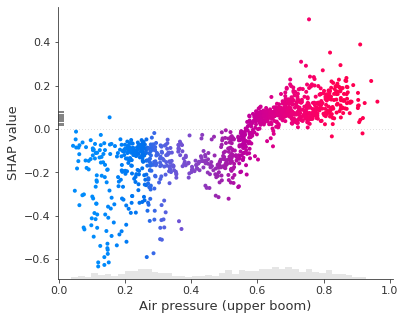

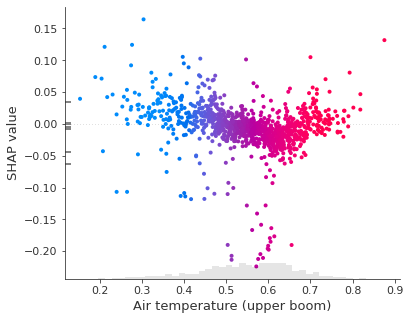

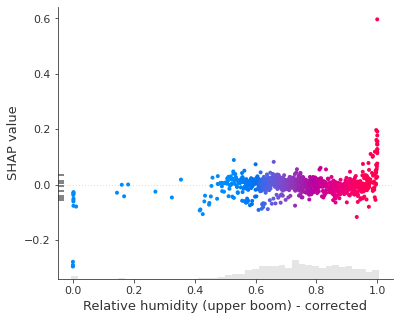

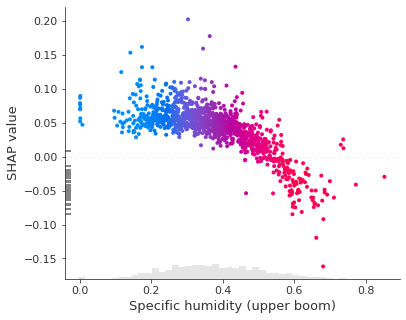

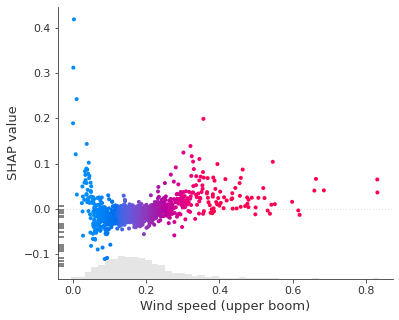

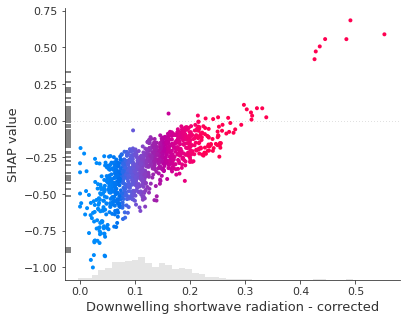

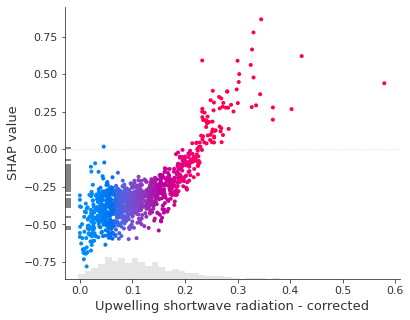

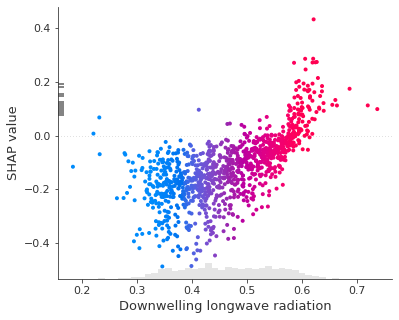

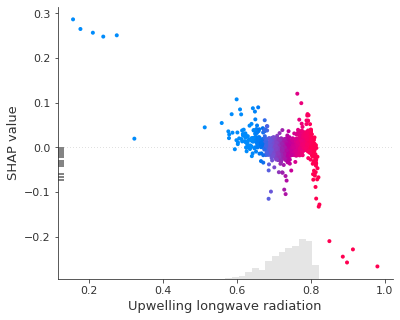

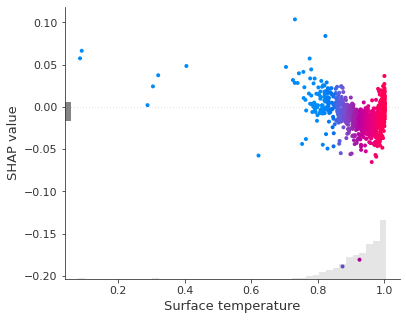

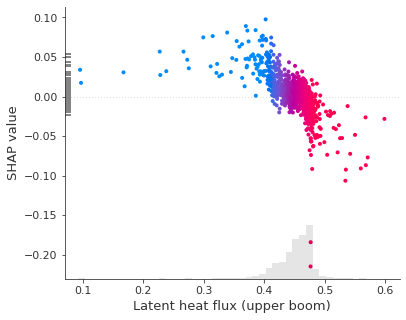

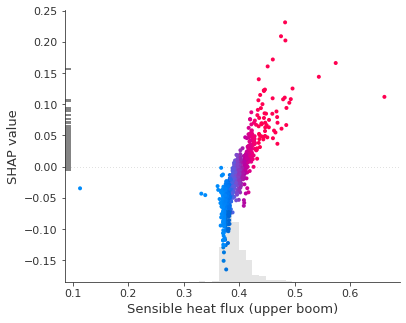

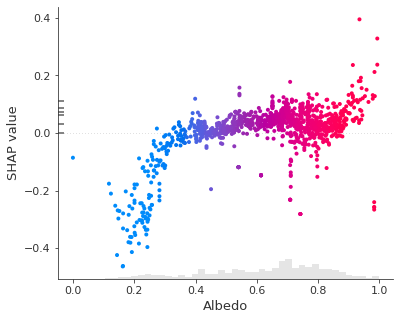

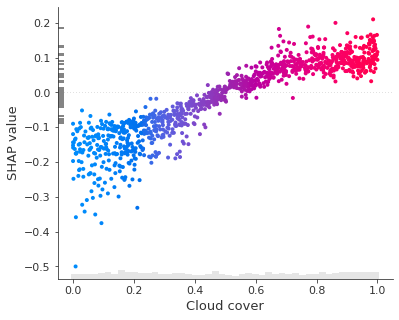

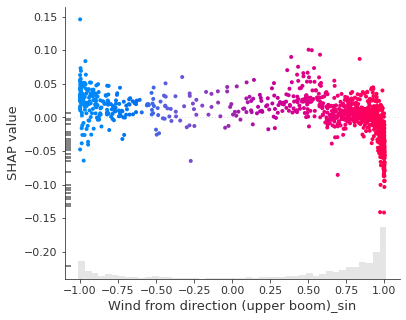

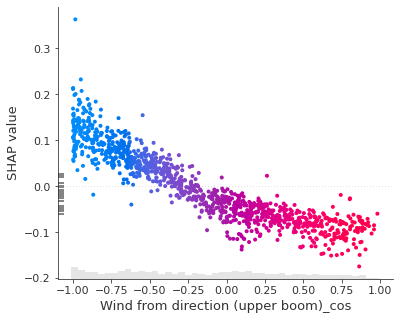

In [69]:
for i in range(17):
    # Create a new Explanation object with the desired feature's SHAP values
    single_feature_shap_values = shap.Explanation(
        shap_values[:, i].reshape(-1, 1),
        explainer.expected_value,
        #X_set.loc[filter].values[:, i].reshape(-1, 1),
        X.values[:, i].reshape(-1, 1),
        feature_names=[X_set.columns[i]]
    )
    shap.plots.scatter(single_feature_shap_values, color=single_feature_shap_values)
    

-------